# Unsupervised Learning: Trade&Ahead

**Marks: 50**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# --- For KMeans -----

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# --- For Hierarchical -----

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To suppress the warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [3]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## Data Overview

- Observations
- Sanity checks

In [4]:
# loading the dataset
data = pd.read_csv('stock_data.csv')
# make a copy of the dataset to avoid changes in original dataset
df = data.copy()

In [5]:
data.head()

Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
0                  6.681299e+08    3.718174  -8.784219  
1                  1.633016e+09   18.806350  -8.750068  
2                  1.504422e+09   15.275510  -0.394171  
3                  4.996437e+08   74.555557   4.199651  
4                  2.247994e+09  178.451613   1.059810

In [6]:
data.shape

(340, 15)

The dataset contains 340 rows and 15 columns

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

- 3 datatypes: object(4 columns), float64(7 columns) and int64 (4 columns)
- There are no null values in the dataset

In [8]:
# Ticker_symbol is insignificant so drop it
df.drop('Ticker Symbol', axis=1, inplace= True)
df.head()

Security             GICS Sector      GICS Sub Industry  \
0  American Airlines Group             Industrials               Airlines   
1                   AbbVie             Health Care        Pharmaceuticals   
2      Abbott Laboratories             Health Care  Health Care Equipment   
3        Adobe Systems Inc  Information Technology   Application Software   
4     Analog Devices, Inc.  Information Technology         Semiconductors   

   Current Price  Price Change  Volatility  ROE  Cash Ratio  Net Cash Flow  \
0      42.349998      9.999995    1.687151  135          51     -604000000   
1      59.240002      8.339433    2.197887  130          77       51000000   
2      44.910000     11.301121    1.273646   21          67      938000000   
3      93.940002     13.977195    1.357679    9         180     -240840000   
4      55.320000     -1.827858    1.701169   14         272      315120000   

   Net Income  Earnings Per Share  Estimated Shares Outstanding   P/E Ratio  \
0  7610000000               11.39                  6.681299e+08    3.718174   
1  5144000000                3.15                  1.633016e+09   18.806350   
2  4423000000                2.94                  1.504422e+09   15.275510   
3   629551000                1.26                  4.996437e+08   74.555557   
4   696878000                0.31                  2.247994e+09  178.451613   

   P/B Ratio  
0  -8.784219  
1  -8.750068  
2  -0.394171  
3   4.199651  
4   1.059810

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Univariate Analysis

**Categorical Columns**

In [9]:
# summary of categorical columns
df.describe(include ='object').T

count unique                                 top freq
Security            340    340             American Airlines Group    1
GICS Sector         340     11                         Industrials   53
GICS Sub Industry   340    104  Oil & Gas Exploration & Production   16

- There are total 11 GIS Sector
- Total 104 GICS Sub Industries

**GIS Sector**

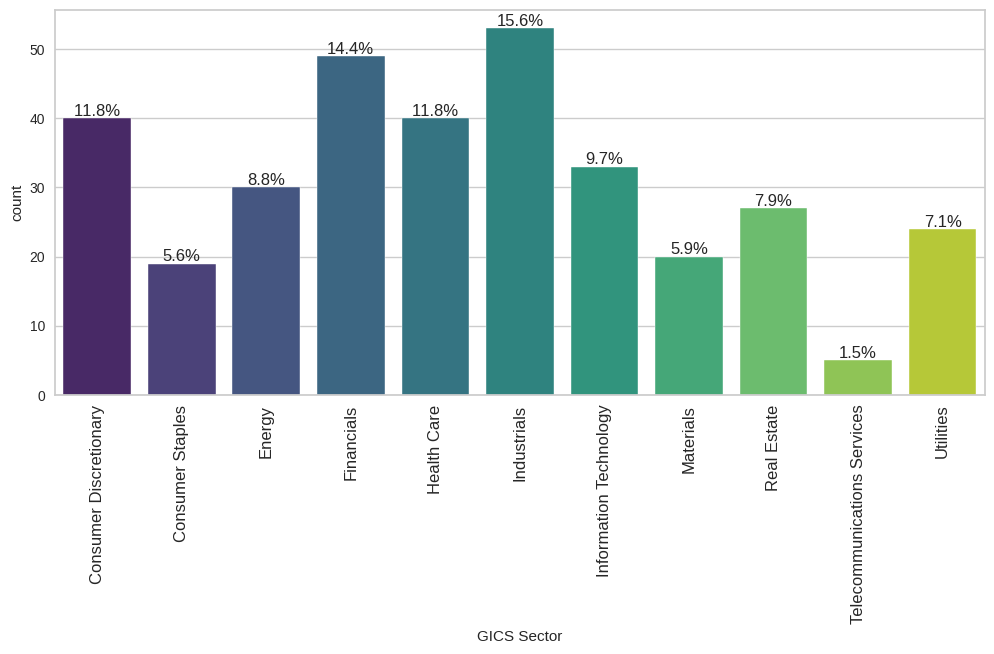

In [10]:
labeled_barplot(df, 'GICS Sector',perc=True)

In [11]:
# five sectors with most no of stocks
df['GICS Sector'].value_counts().head(5)

Industrials               53
Financials                49
Health Care               40
Consumer Discretionary    40
Information Technology    33
Name: GICS Sector, dtype: int64

- Industrials contains 15.6% of the stocks followed by  Finacials (14.4%),
Health Care (11.8%) and consumer discretionary (11.8%)
- Telecommunication Services have the lowest stocks

**GIS Sub Industry**

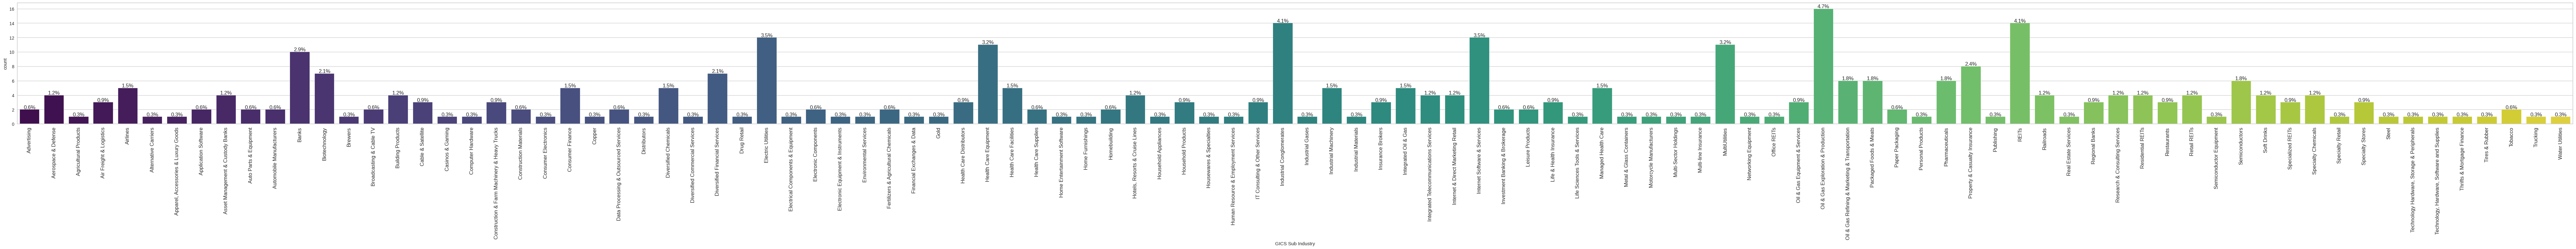

In [12]:
labeled_barplot(df, 'GICS Sub Industry', perc=True)

In [13]:
# five sub industries with most no of stocks
df['GICS Sub Industry'].value_counts().head(5)

Oil & Gas Exploration & Production    16
REITs                                 14
Industrial Conglomerates              14
Electric Utilities                    12
Internet Software & Services          12
Name: GICS Sub Industry, dtype: int64

- There are total 104 sub industries with Oil & Gas having most number of stocks (16)

**Numerical Columns**

In [14]:
#format numeric data for easier readability
pd.set_option("display.float_format", lambda x: "%.2f" % x)  # to display numbers rounded off to 2 decimal places
# summary of numerical columns
data.describe().T

count          mean           std  \
Current Price                340.00         80.86         98.06   
Price Change                 340.00          4.08         12.01   
Volatility                   340.00          1.53          0.59   
ROE                          340.00         39.60         96.55   
Cash Ratio                   340.00         70.02         90.42   
Net Cash Flow                340.00   55537620.59 1946365312.18   
Net Income                   340.00 1494384602.94 3940150279.33   
Earnings Per Share           340.00          2.78          6.59   
Estimated Shares Outstanding 340.00  577028337.75  845849595.42   
P/E Ratio                    340.00         32.61         44.35   
P/B Ratio                    340.00         -1.72         13.97   

                                         min           25%          50%  \
Current Price                           4.50         38.55        59.70   
Price Change                          -47.13         -0.94         4.82   
Volatility                              0.73          1.13         1.39   
ROE                                     1.00          9.75        15.00   
Cash Ratio                              0.00         18.00        47.00   
Net Cash Flow                -11208000000.00 -193906500.00   2098000.00   
Net Income                   -23528000000.00  352301250.00 707336000.00   
Earnings Per Share                    -61.20          1.56         2.90   
Estimated Shares Outstanding     27672156.86  158848216.10 309675137.80   
P/E Ratio                               2.94         15.04        20.82   
P/B Ratio                             -76.12         -4.35        -1.07   

                                       75%            max  
Current Price                        92.88        1274.95  
Price Change                         10.70          55.05  
Volatility                            1.70           4.58  
ROE                                  27.00         917.00  
Cash Ratio                           99.00         958.00  
Net Cash Flow                 169810750.00 20764000000.00  
Net Income                   1899000000.00 24442000000.00  
Earnings Per Share                    4.62          50.09  
Estimated Shares Outstanding  573117457.32  6159292035.00  
P/E Ratio                            31.76         528.04  
P/B Ratio                             3.92         129.06

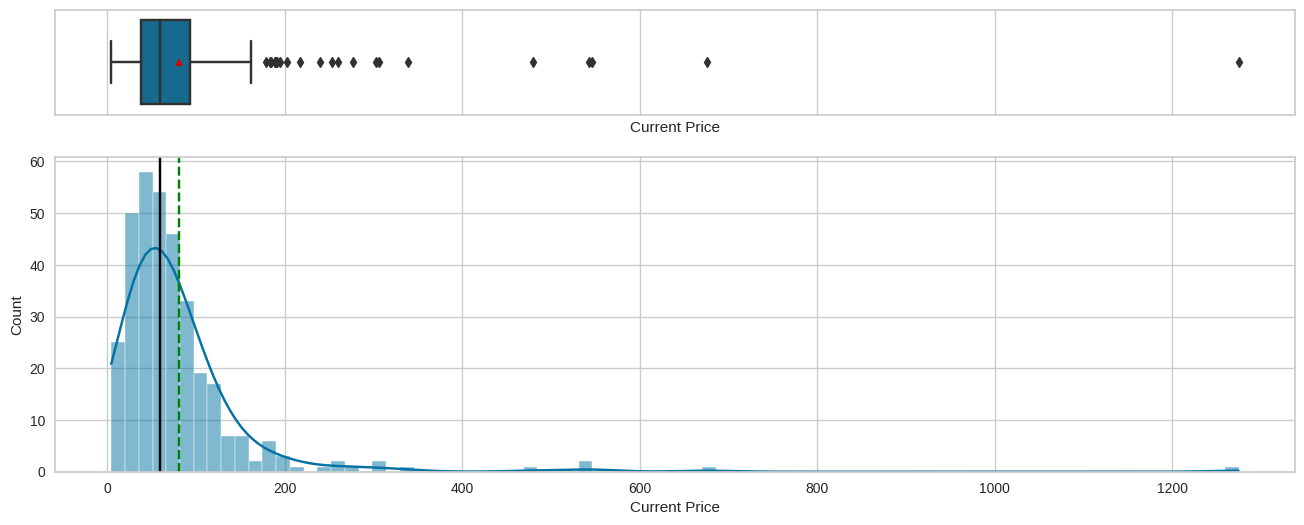

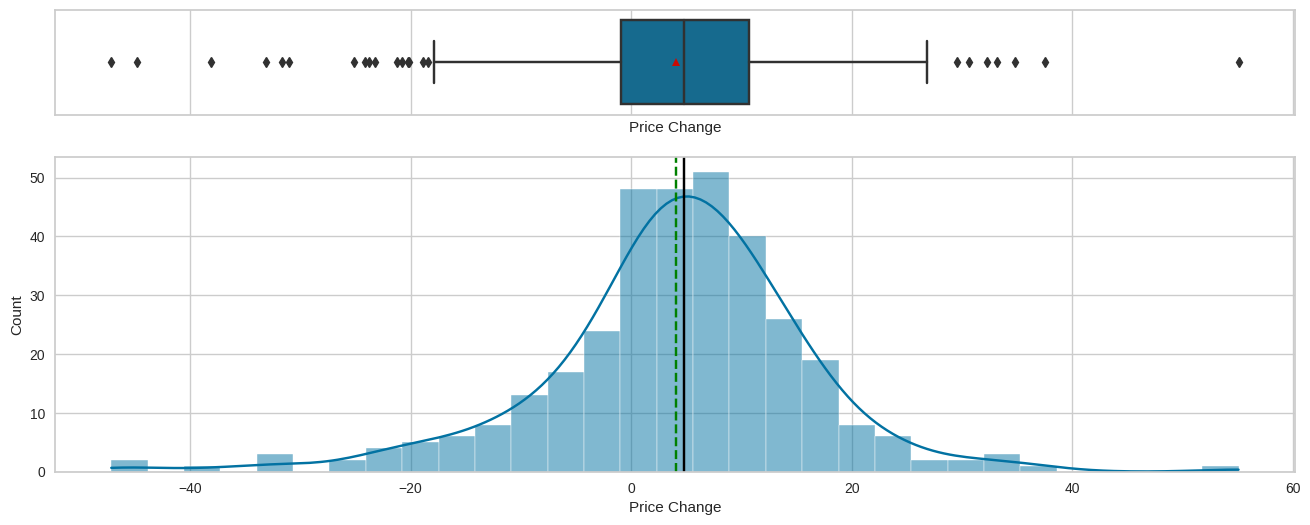

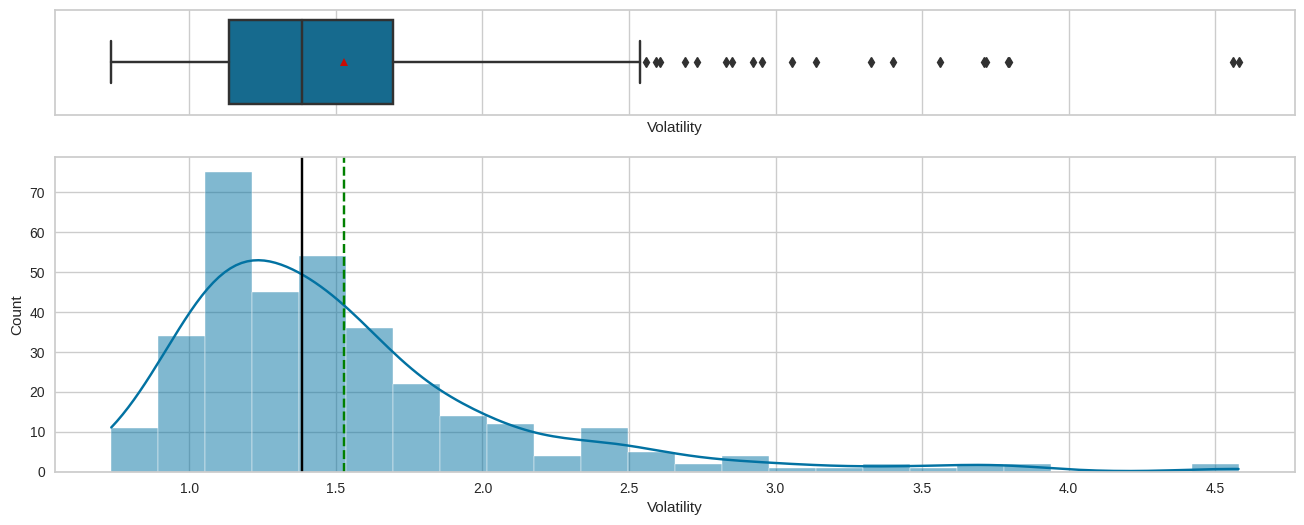

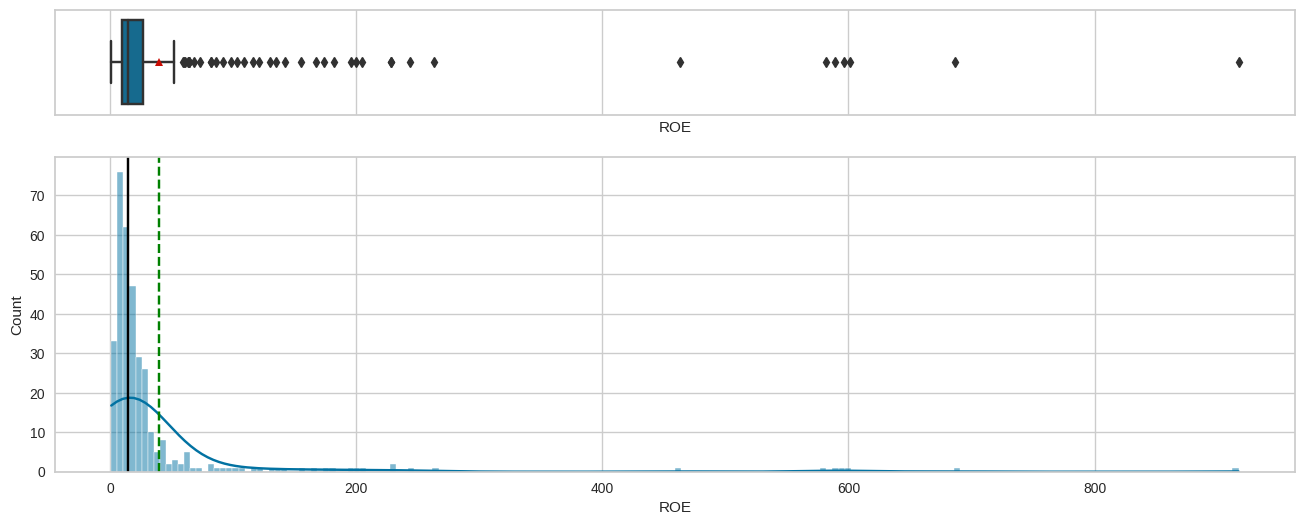

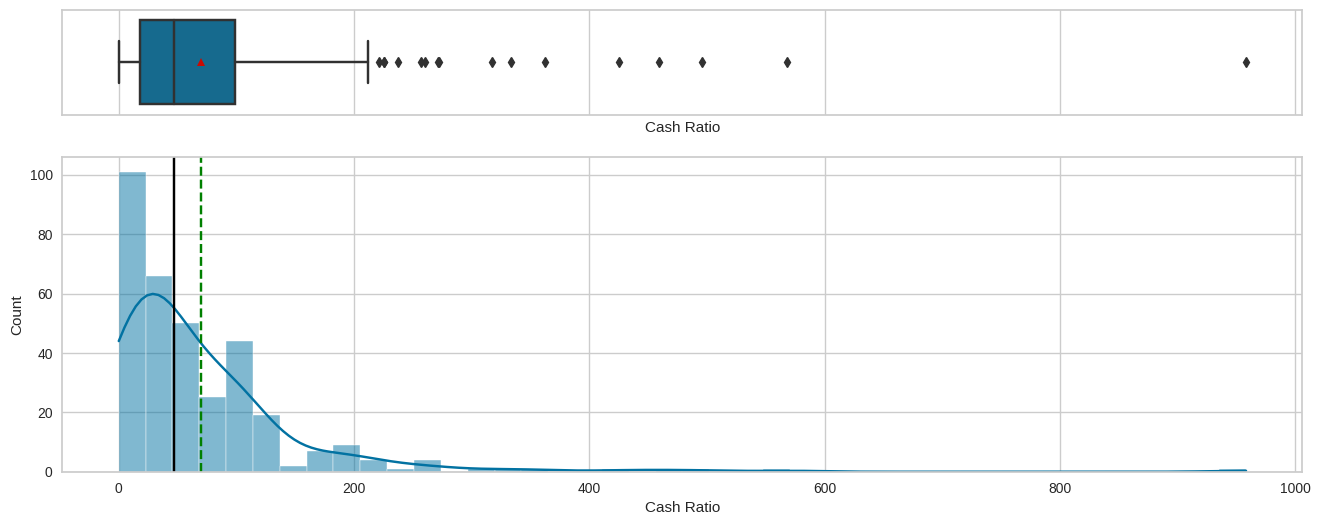

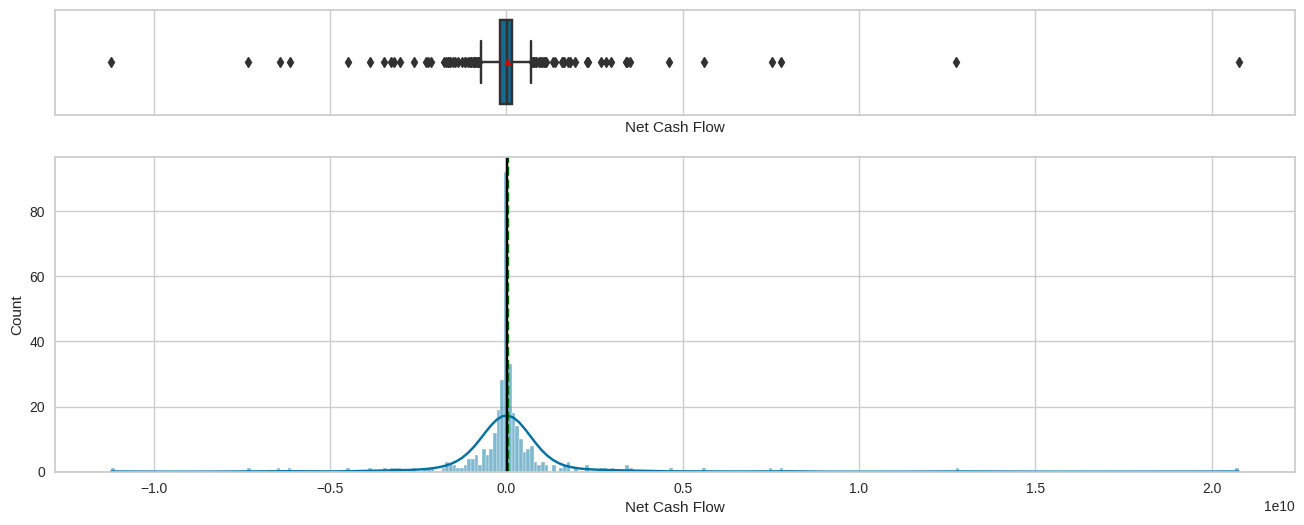

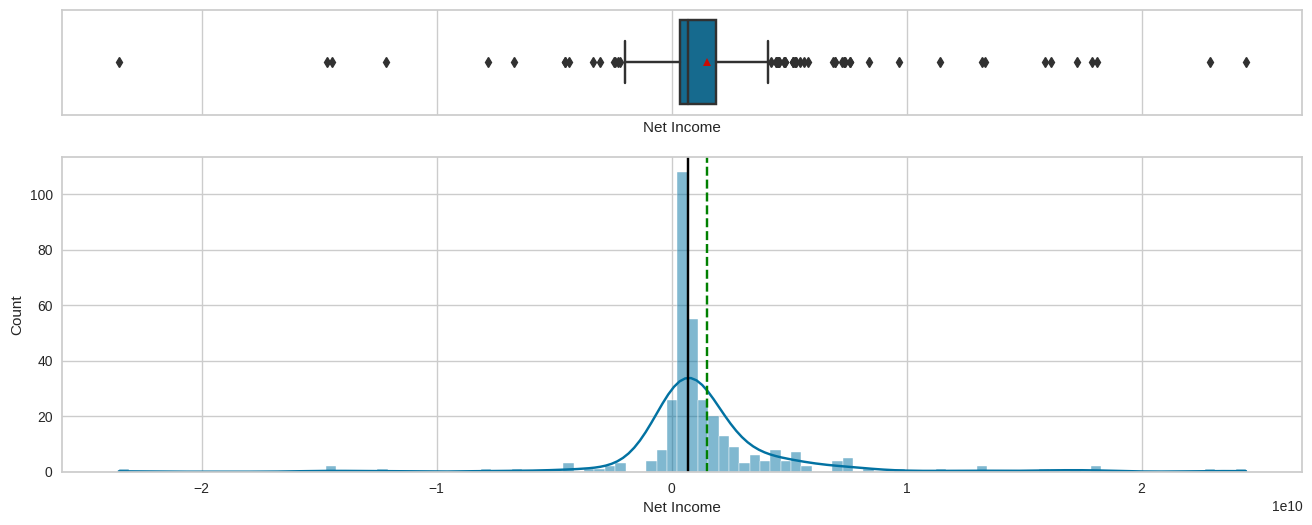

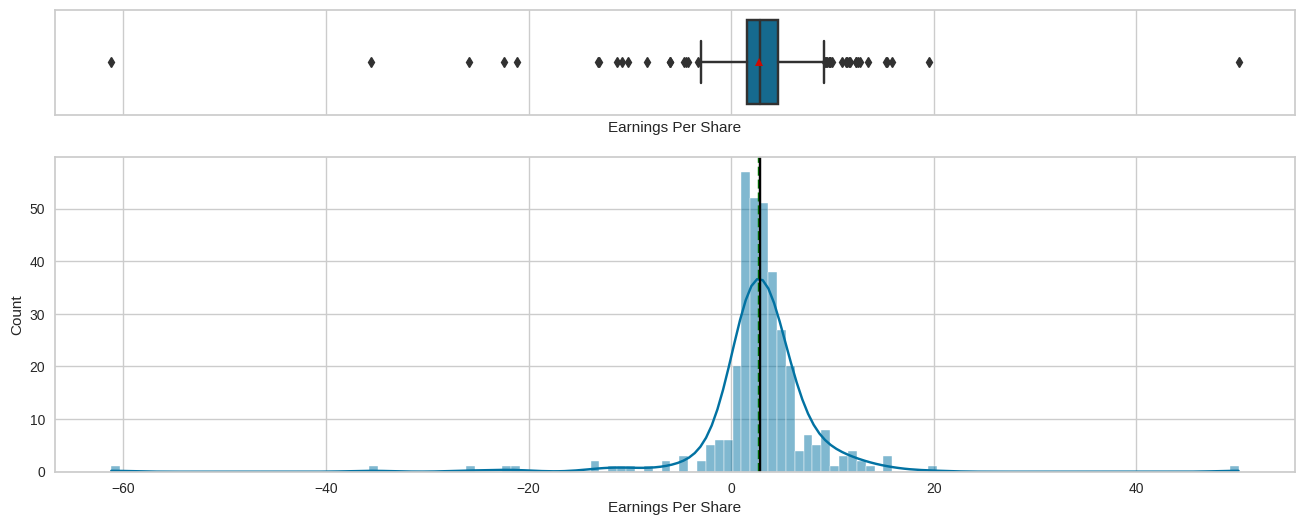

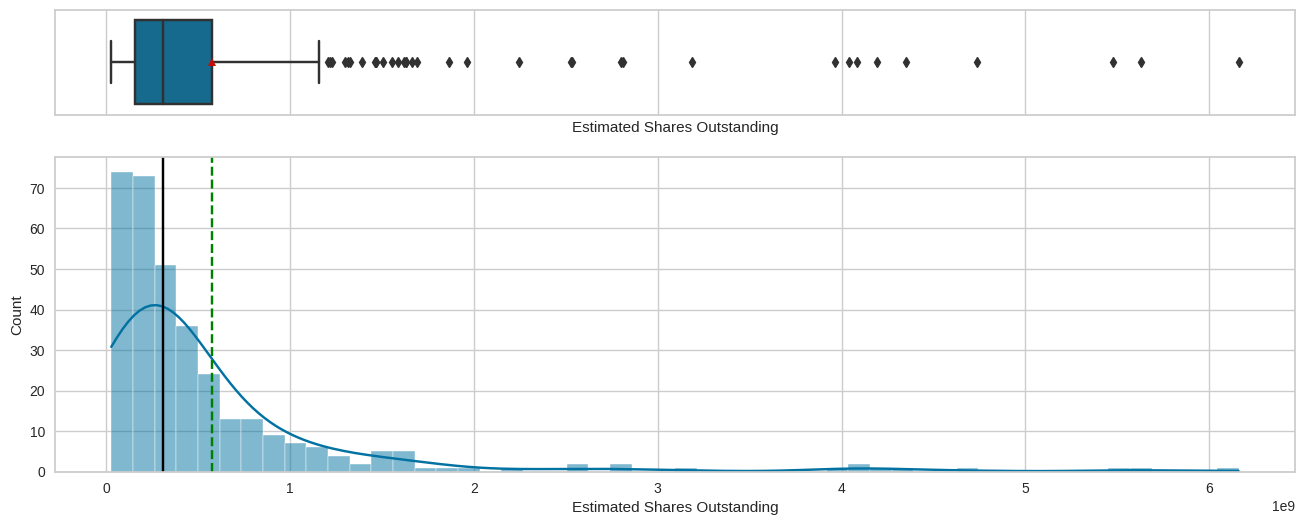

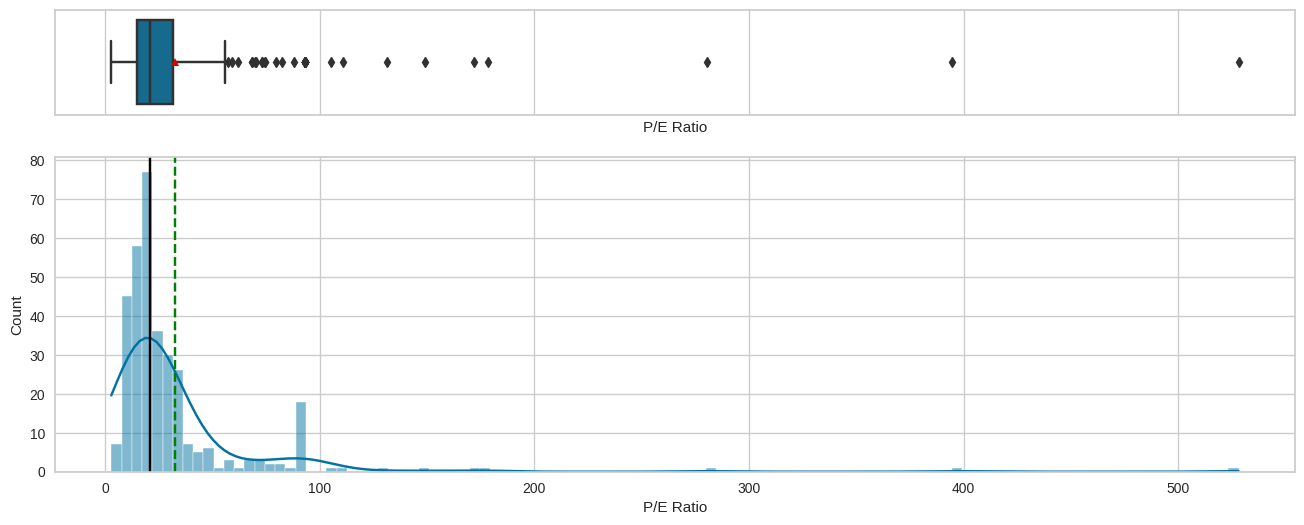

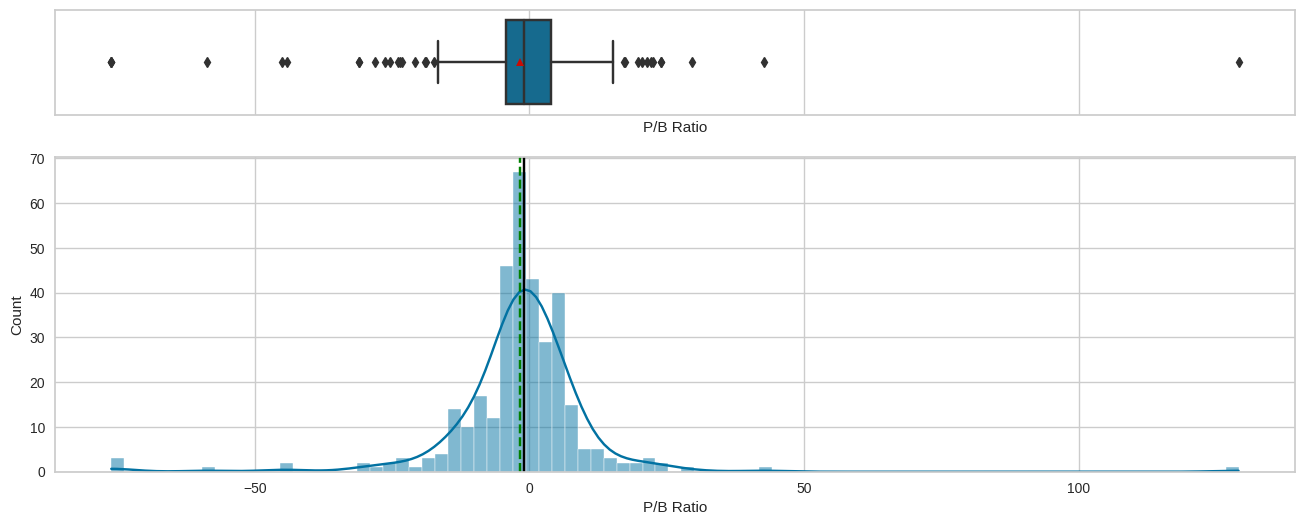

In [15]:
#create list of numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

#display histograms and boxplots for all numerical columns
for col in num_col:
    histogram_boxplot(df, col,kde=True)

- Almost normal distribution with long tails on
both sides, having both negative and positive outliers:

  - Price Change

  - Net Cash flow

  - Net income

  - Earning Per Share

  - P/B ratio

- Right skewed distribution with positive outliers:
    - Current Price
    - Volatility
    - ROE
    - Cash Ratio
    - Estimated Shares Outstanding
    - P/E ratio




### Bivariate Analysis

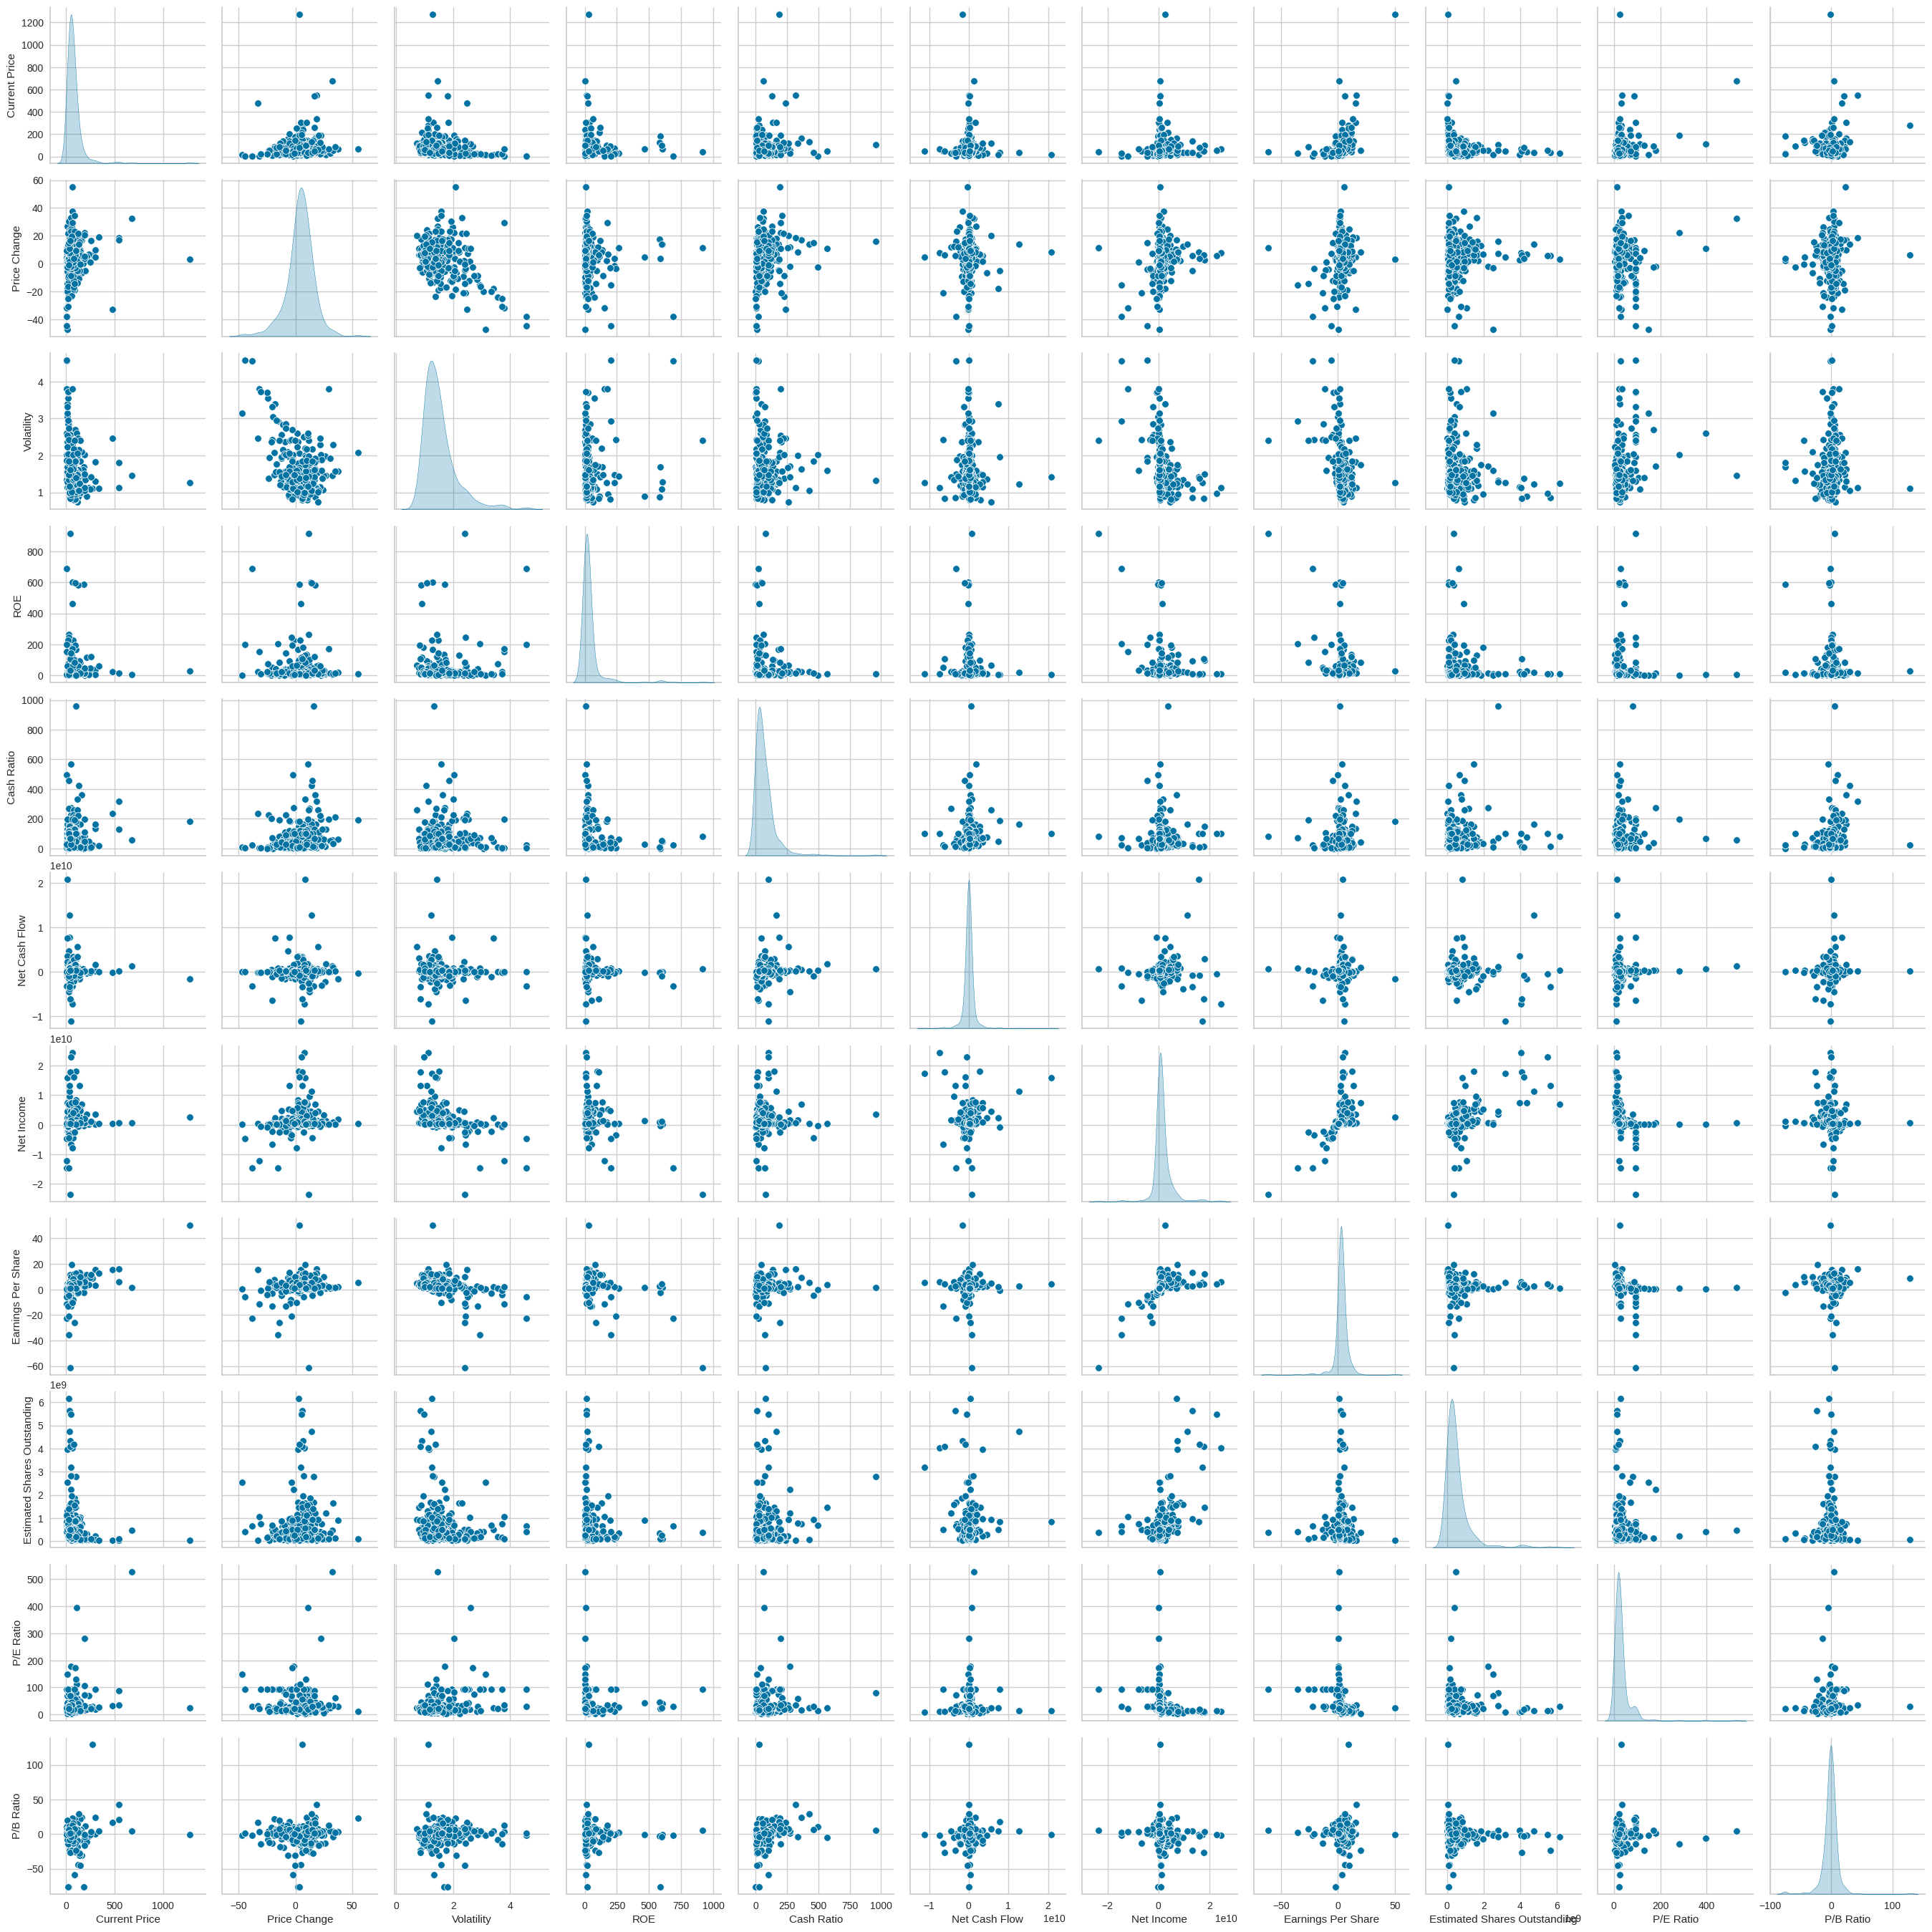

In [17]:
# pairplot
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

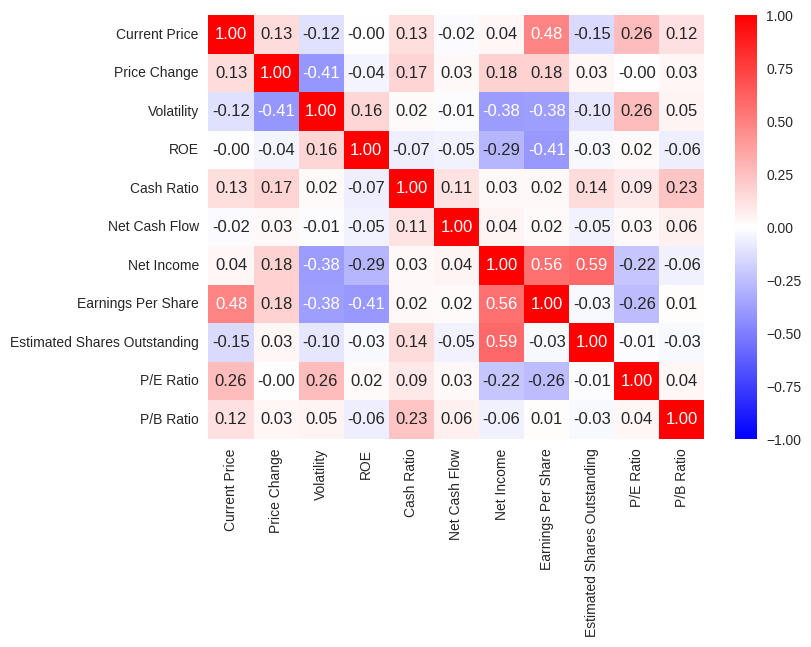

In [28]:
# heatmap
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt='.2f',cmap='bwr')
plt.show()


- Positive Correlation:
  - Current price & Earnings per share (R$^2$ = 0.48)
  - Net income & Earnings per share (R$^2$ = 0.56)
  - Net income & Estimated shares outstanding (R$^2$ = 0.59)

which is obvious as earning per share and share outstanding increase, net income will also increase

- Negative Correlation:
  - Price change & Volatility (R$^2$ = -0.41)
  - Net income & Volatility (R$^2$ = -0.38)
  - Earning per share & Volatility (R$^2$ = -0.38)
  - Earning per share & ROE (R$^2$ = -0.41)

which is again understandable as more negative the price change the more voltaile the stock becomes

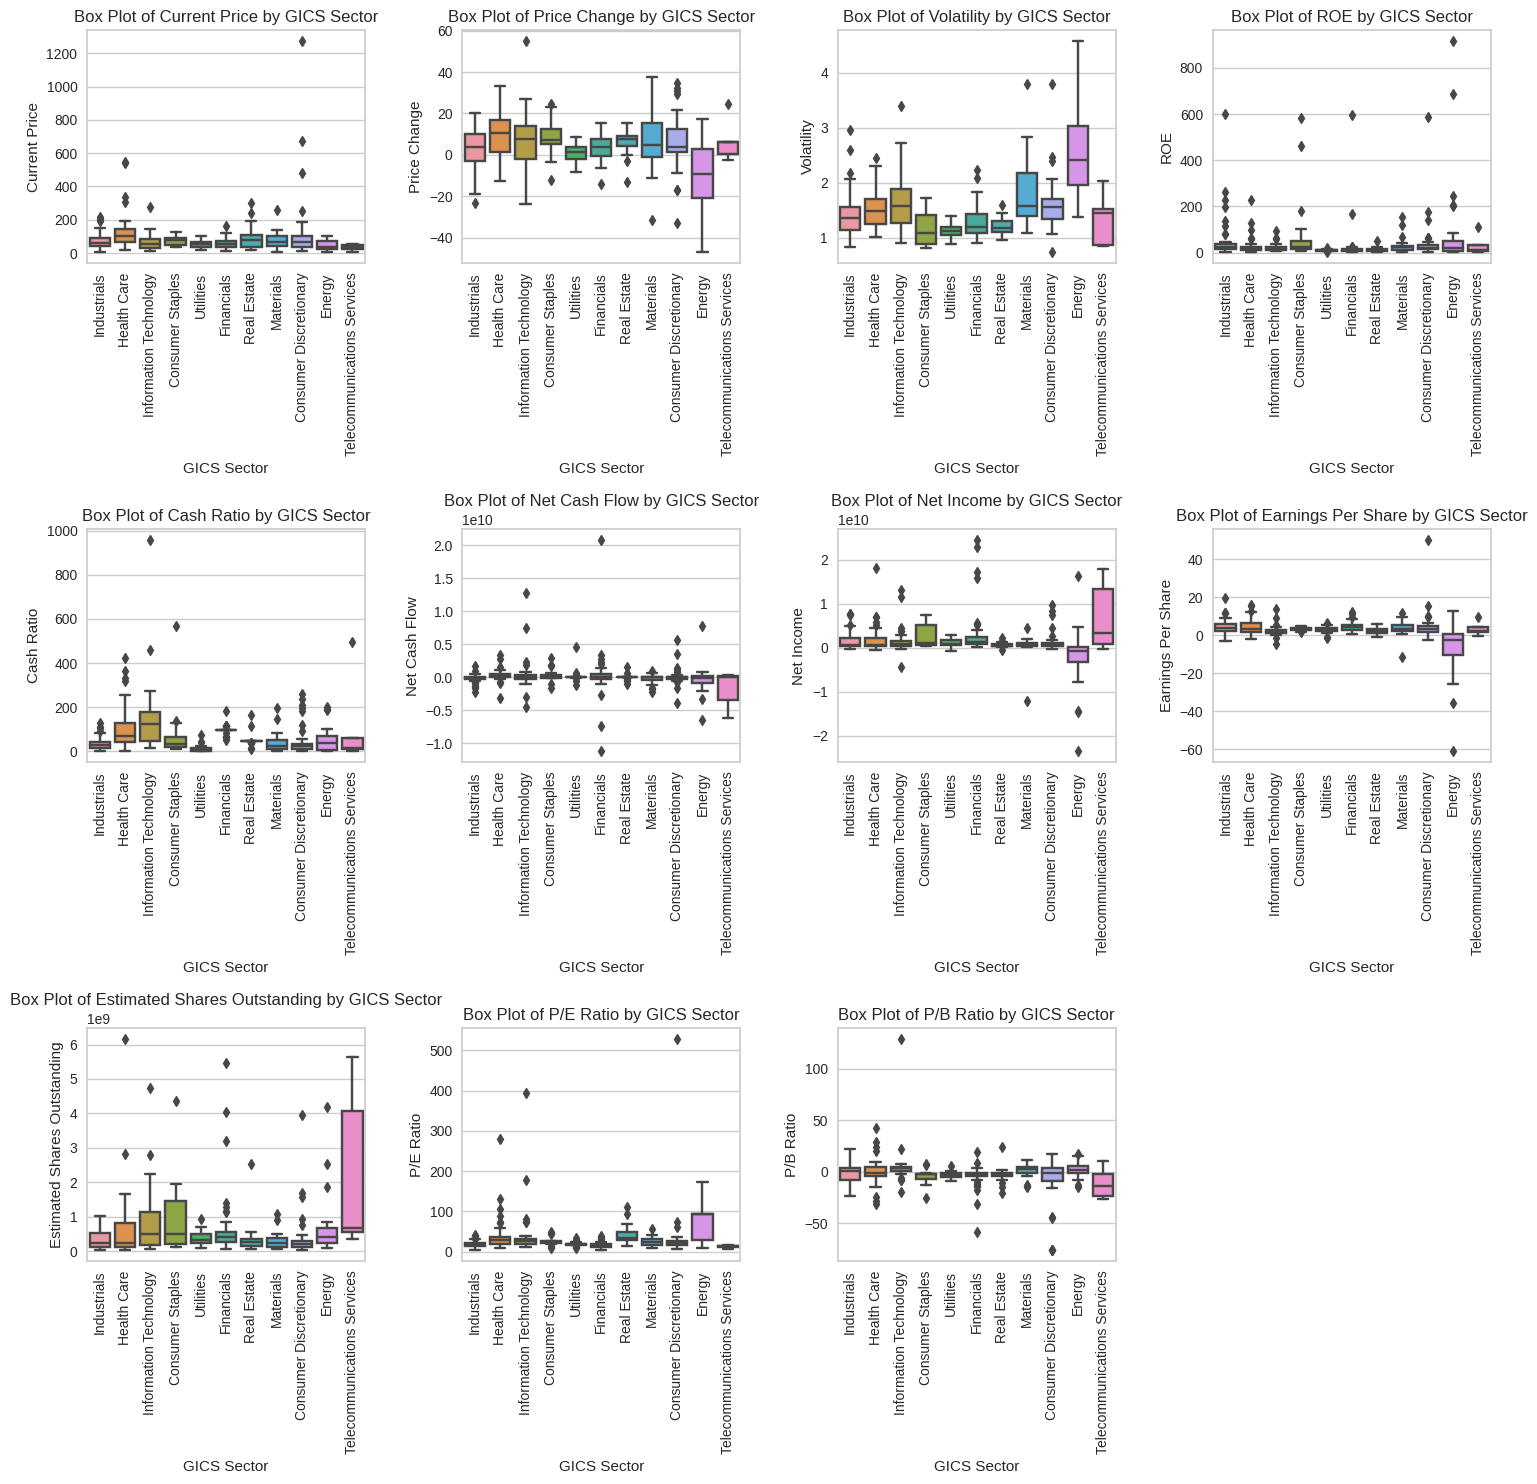

In [49]:
# Numerical columns vs GIS sectors
plt.figure(figsize=(15, 15))
for i, col in enumerate(num_col):
    plt.subplot(3,4, i+1)
    sns.boxplot(data=df, x='GICS Sector', y=col)
    plt.tight_layout()
    plt.xlabel('GICS Sector')
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.title(f'Box Plot of {col} by GICS Sector')

- Current price, ROE,cash ratio and net cash flow have similar variance across the GIS sectors
-Price change, Volatility, Earnings per share and P/E ratio also have similar varience except Energy having a higher variance in all 3
- Similar variance for Net income, Estimated Shares Outstanding and P/B ratio except telecommunication services having a higher variance in all 3




**The stocks of which economic sector have seen the maximum price increase on average?**

In [ ]:
df.groupby('GICS Sector')['Price Change'].mean().sort_values()

GICS Sector
Energy                        -10.23
Utilities                       0.80
Industrials                     2.83
Financials                      3.87
Materials                       5.59
Consumer Discretionary          5.85
Real Estate                     6.21
Telecommunications Services     6.96
Information Technology          7.22
Consumer Staples                8.68
Health Care                     9.59
Name: Price Change, dtype: float64

The stocks of Healthcare have seen the maximum price increase on average.

**Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?**

In [29]:
df.groupby('GICS Sector')['Cash Ratio'].mean().sort_values(ascending=False)

GICS Sector
Information Technology        149.82
Telecommunications Services   117.00
Health Care                   103.78
Financials                     98.59
Consumer Staples               70.95
Energy                         51.13
Real Estate                    50.11
Consumer Discretionary         49.58
Materials                      41.70
Industrials                    36.19
Utilities                      13.62
Name: Cash Ratio, dtype: float64

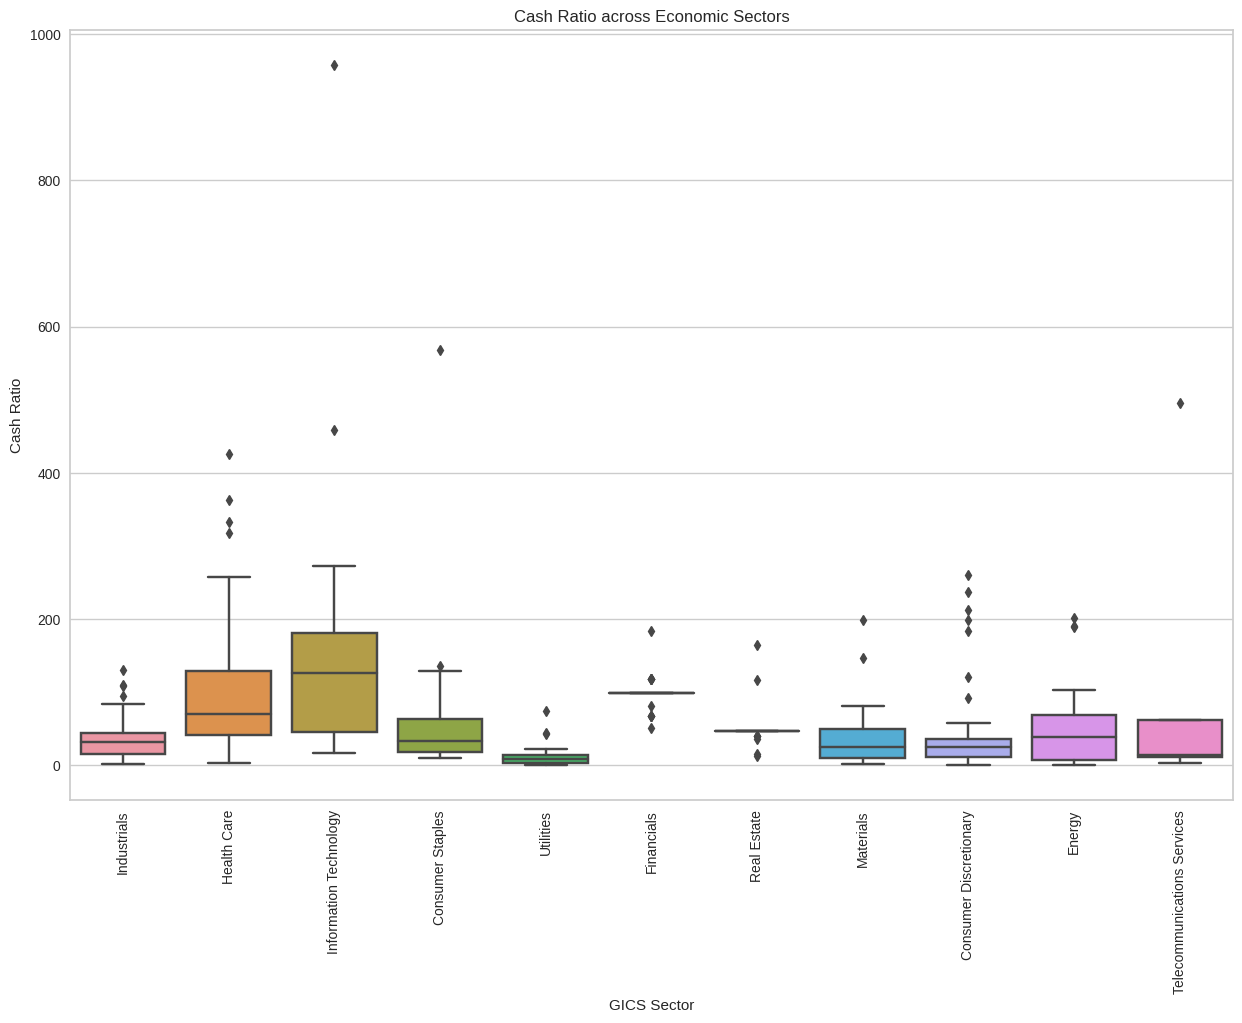

In [36]:
plt.figure(figsize=(15,10))
sns.boxplot(data = df, y = 'Cash Ratio', x = 'GICS Sector')
plt.title("Cash Ratio across Economic Sectors");
plt.xticks(rotation=90)
plt.show()

- Top 3 sectors by avergae Cash ratio are: Information Technology > Telecommunications Services > Health Care
- IT industry also have highest median and variance cash ratio and highest positive outlers
- Utilities have lowest average cash ratio
- Financilas and Real estate have minimum variance in cash ratio

**P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?**

In [ ]:
df.groupby('GICS Sector')['P/E Ratio'].mean().sort_values(ascending=False)

GICS Sector
Energy                        72.90
Information Technology        43.78
Real Estate                   43.07
Health Care                   41.14
Consumer Discretionary        35.21
Consumer Staples              25.52
Materials                     24.59
Utilities                     18.72
Industrials                   18.26
Financials                    16.02
Telecommunications Services   12.22
Name: P/E Ratio, dtype: float64

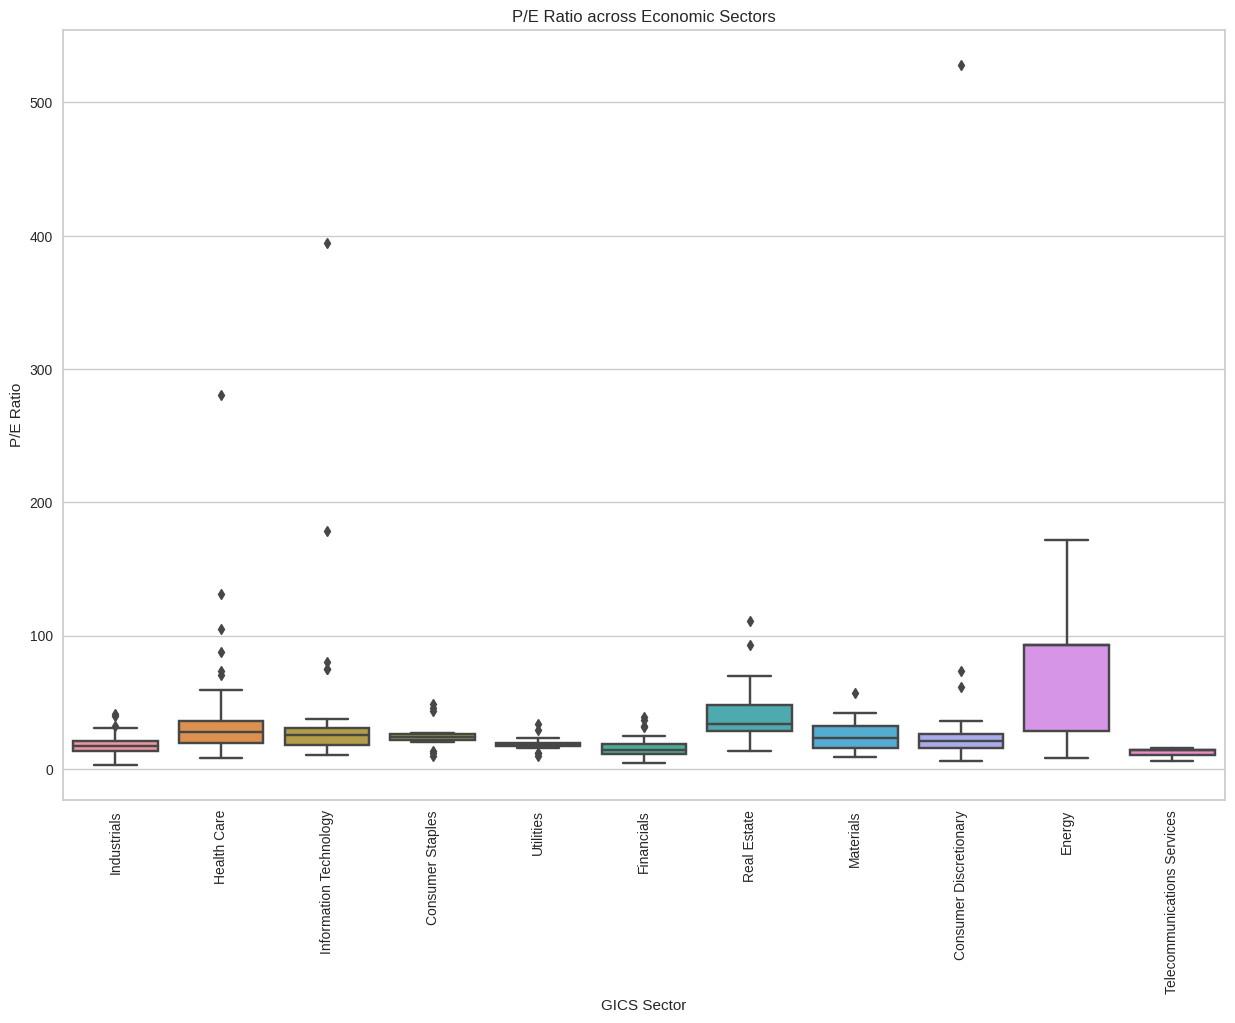

In [37]:
plt.figure(figsize=(15,10))
sns.boxplot(data = df, y = 'P/E Ratio', x = 'GICS Sector')
plt.title("P/E Ratio across Economic Sectors");
plt.xticks(rotation=90)
plt.show()

Energy has the highest average P/E ratio as well as the maximum variance in P/E Ratio

**Questions**:

1. What does the distribution of stock prices look like?
> Right skewed distribution
2. The stocks of which economic sector have seen the maximum price increase on average?
> Healthcare
3. How are the different variables correlated with each other?

  >- Positive Correlation:
    - Current price & Earnings per share (R$^2$ = 0.48)
    - Net income & Earnings per share (R$^2$ = 0.56)
    - Net income & Estimated shares outstanding (R$^2$ = 0.59)

  >- Negative Correlation:
    - Price change & Volatility (R$^2$ = -0.41)
    - Net income & Volatility (R$^2$ = -0.38)
    - Earning per share & Volatility (R$^2$ = -0.38)
    - Earning per share & ROE (R$^2$ = -0.41)



4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
> - Top 3 sectors by avergae Cash ratio are: Information Technology > Telecommunications Services > Health Care
  - IT industry also have highest median and variance cash ratio and highest positive outlers
  - Utilities have lowest average cash ratio
  - Financilas and Real estate have minimum variance in cash ratio
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?
> Energy has the highest average P/E ratio as well as the maximum variance in P/E Ratio

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [40]:
# for checking duplicate values
df.duplicated().sum()

0

In [41]:
# for checking missing values
df.isnull().sum()

Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

No duplicate & missing values present

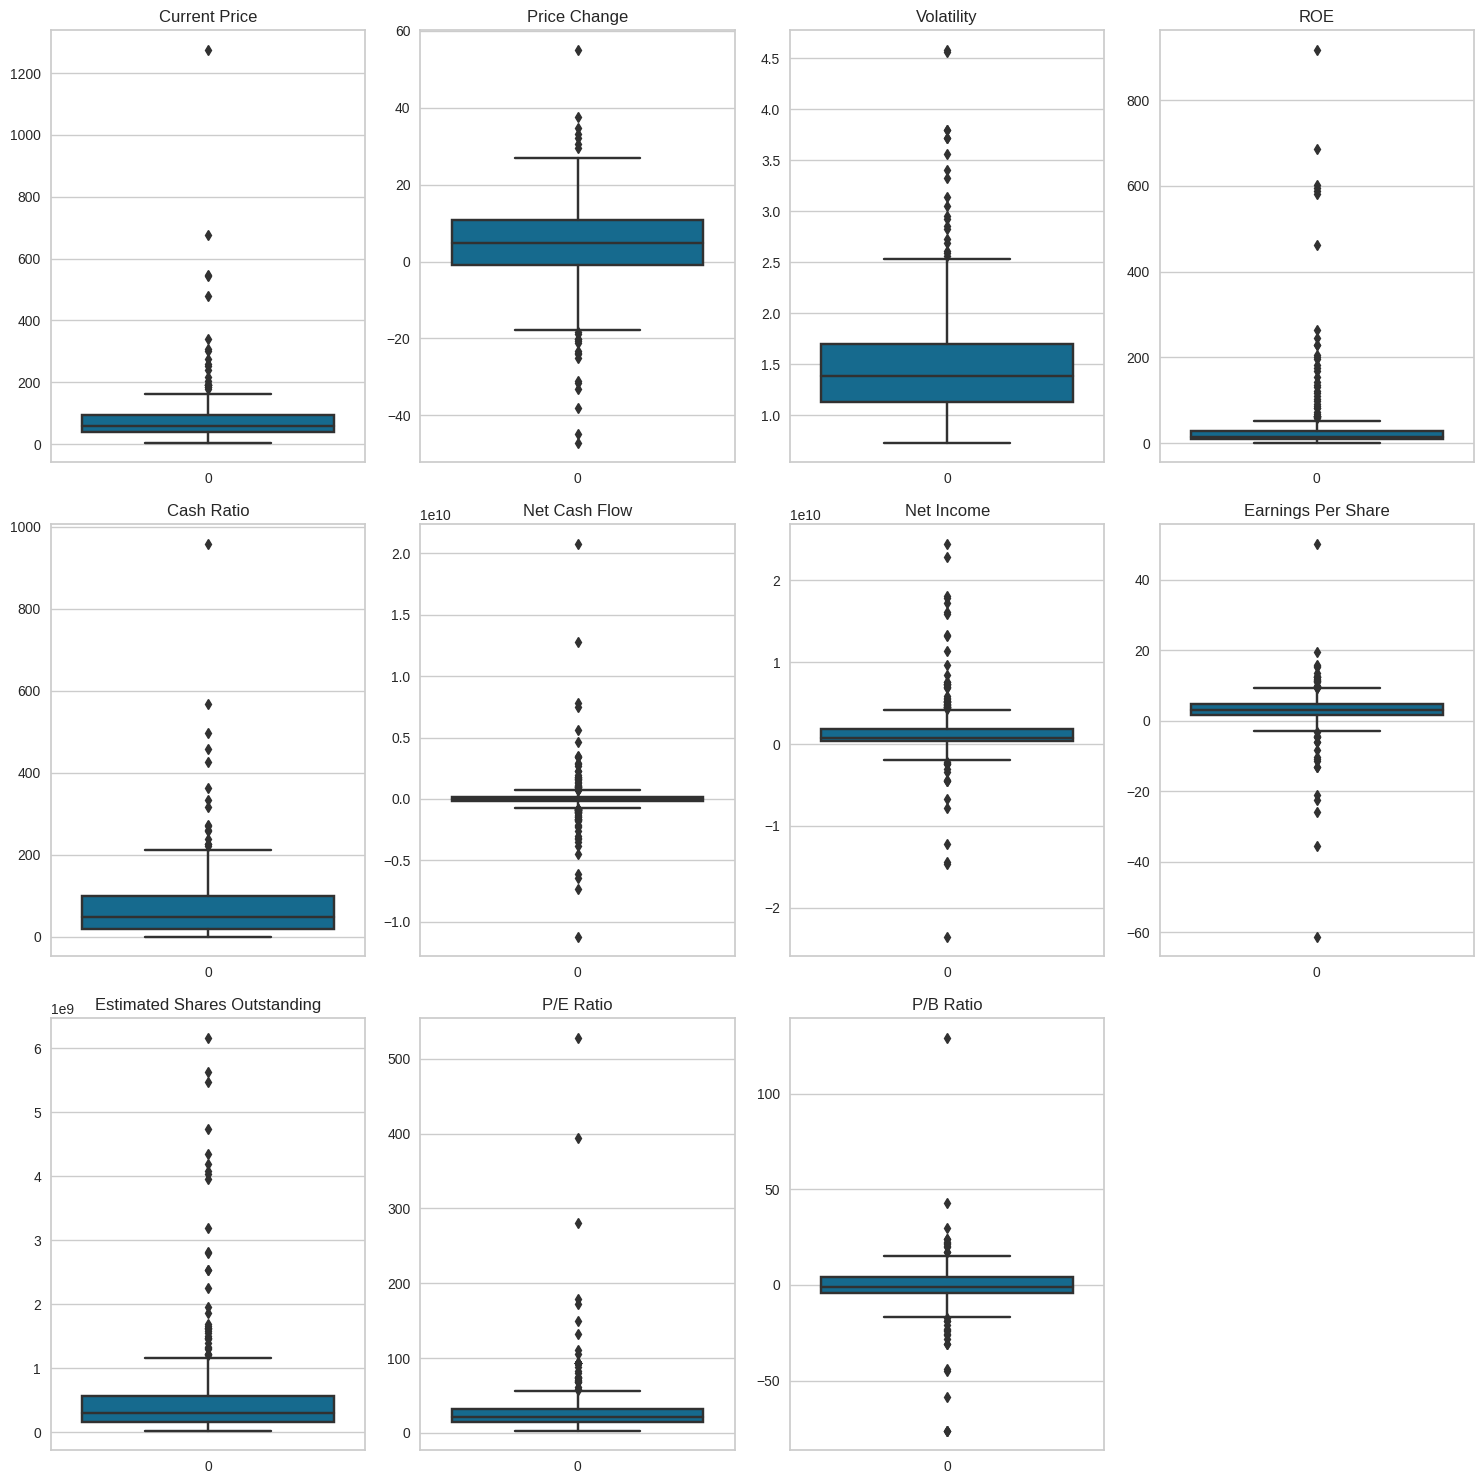

In [47]:
# outliers check using boxplot
plt.figure(figsize=(15, 15))
for i, col in enumerate(num_col):
    plt.subplot(3,4, i+1)
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.title(col)

As seen from the boxplots, there are outliers in the numerical columns of the dataset however all the values of outliers are expected from stock market. So, it is decided to keep them as they are.

**Feature Engineering**

In [54]:
# scaling
scaler = StandardScaler()
subset = df[num_col].copy() # copying the numerical columns only
subset_scaled = scaler.fit_transform(subset)

In [55]:
# dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [57]:
subset_scaled_df.head()

Current Price  Price Change  Volatility   ROE  Cash Ratio  Net Cash Flow  \
0          -0.39          0.49        0.27  0.99       -0.21          -0.34   
1          -0.22          0.36        1.14  0.94        0.08          -0.00   
2          -0.37          0.60       -0.43 -0.19       -0.03           0.45   
3           0.13          0.83       -0.28 -0.32        1.22          -0.15   
4          -0.26         -0.49        0.30 -0.27        2.24           0.13   

   Net Income  Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  \
0        1.55                1.31                          0.11      -0.65   
1        0.93                0.06                          1.25      -0.31   
2        0.74                0.02                          1.10      -0.39   
3       -0.22               -0.23                         -0.09       0.95   
4       -0.20               -0.37                          1.98       3.29   

   P/B Ratio  
0      -0.51  
1      -0.50  
2       0.09  
3       0.42  
4       0.20

## EDA

- It is a good idea to explore the data once again after manipulating it.

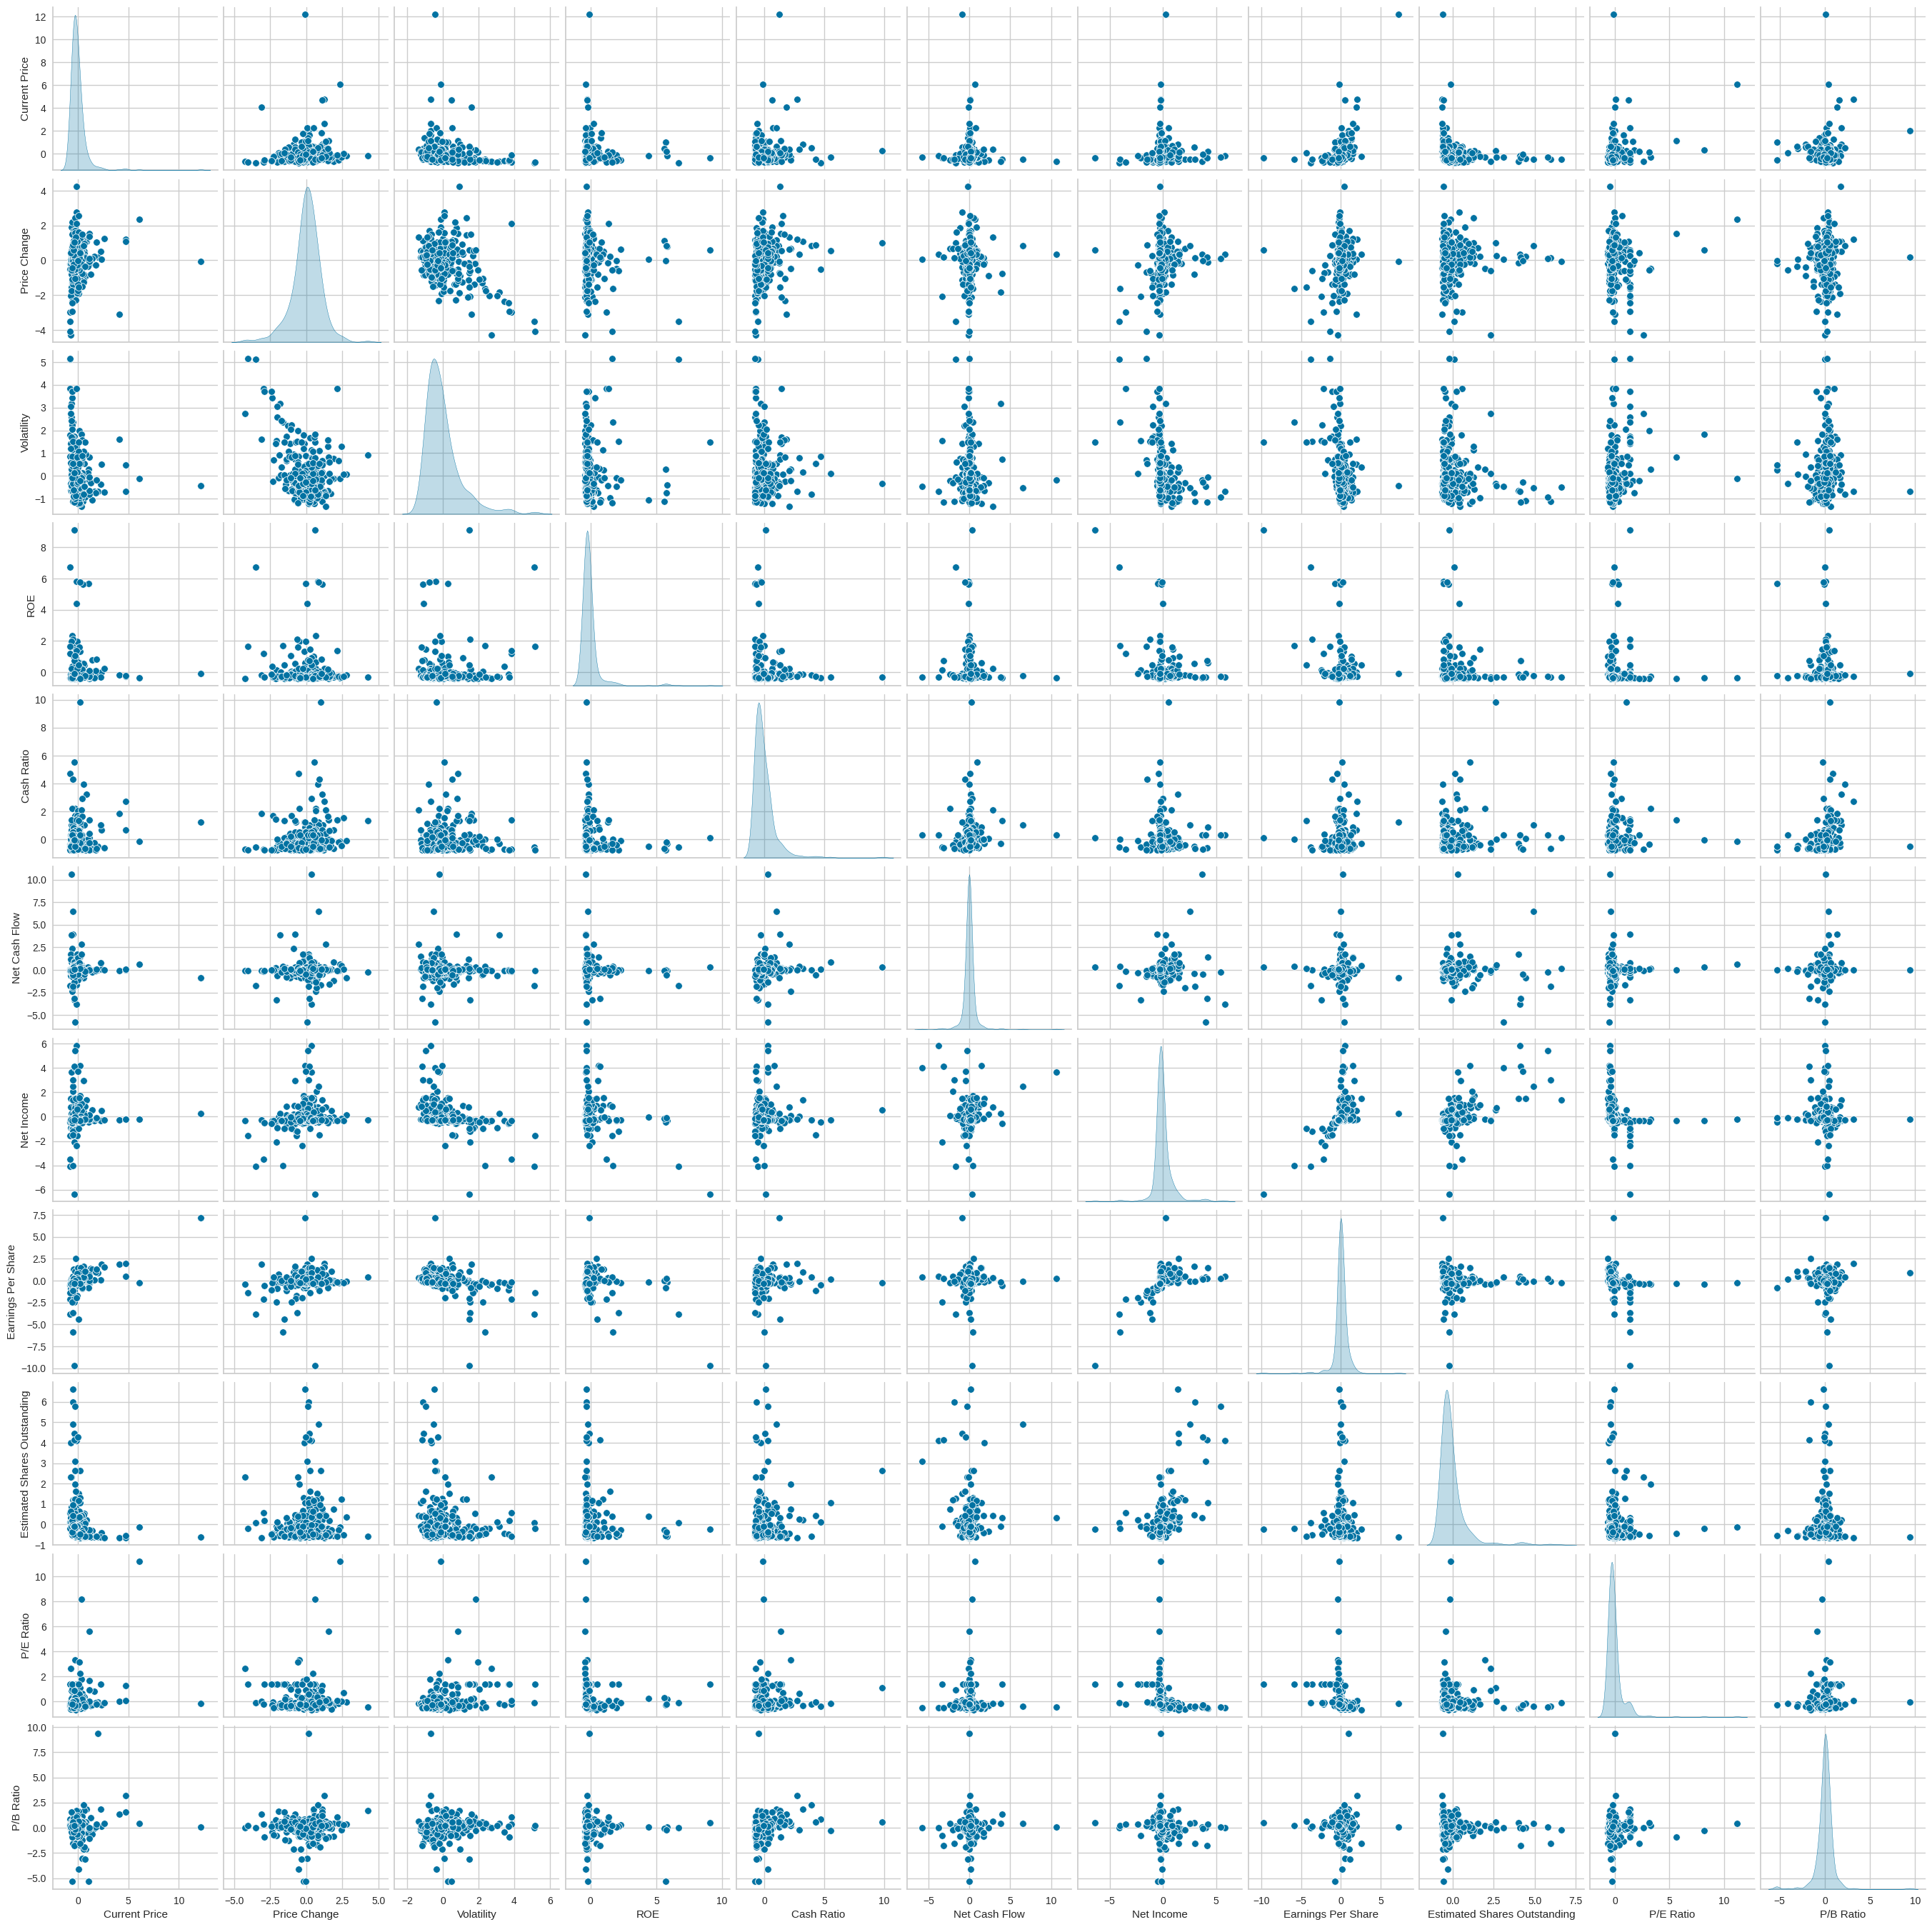

In [56]:
# pair plot
sns.pairplot(data=subset_scaled_df, diag_kind="kde")
plt.show()

**Summary**:
- No missing values
- No duplicate values
- Outliers detected but not treated as they are real values not anomalies
- The data has been scaled, with an average of 0 and standared deviation of 1. The relationsip between the variables after scalling remains intact.

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.377354137922532
Number of Clusters: 3 	Average Distortion: 2.2692367155390745
Number of Clusters: 4 	Average Distortion: 2.178151429073042
Number of Clusters: 5 	Average Distortion: 2.1295231122469365
Number of Clusters: 6 	Average Distortion: 2.069402881418923
Number of Clusters: 7 	Average Distortion: 2.0389548715741967
Number of Clusters: 8 	Average Distortion: 1.972796452526346
Number of Clusters: 9 	Average Distortion: 1.9052569389855731
Number of Clusters: 10 	Average Distortion: 1.8621898703889386


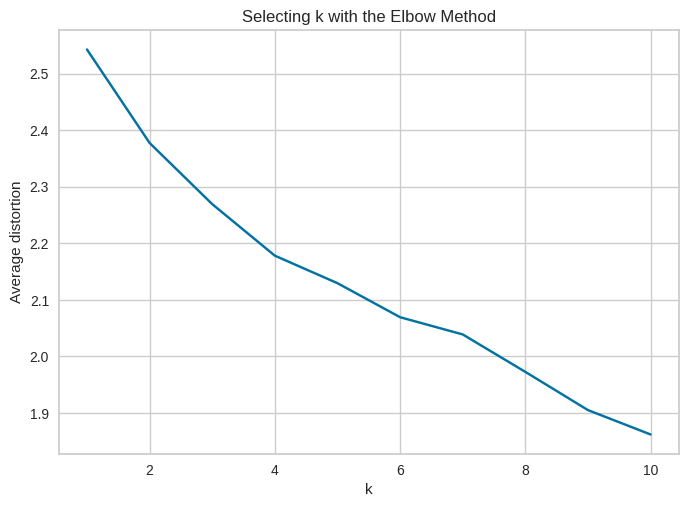

In [77]:
clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Appropriate value for k seems to be 4, 5 or 6, even 7

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.45547866229080475)
For n_clusters = 4, the silhouette score is 0.4519572461604323)
For n_clusters = 5, the silhouette score is 0.3776937496108599)
For n_clusters = 6, the silhouette score is 0.37812651554729454)
For n_clusters = 7, the silhouette score is 0.38105087369742097)
For n_clusters = 8, the silhouette score is 0.42088995653905553)
For n_clusters = 9, the silhouette score is 0.4079882050566609)
For n_clusters = 10, the silhouette score is 0.1230909080891277)


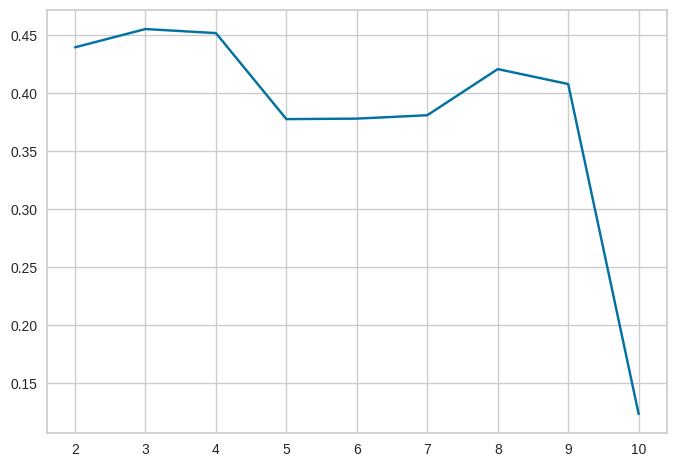

In [78]:
# checking the silhoutte score
sil_score = []
cluster_list = list(range(2, 11))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

Silhouette score for 4 is higher than that for 5, 6 & 7. So, we will choose 4 as value of k

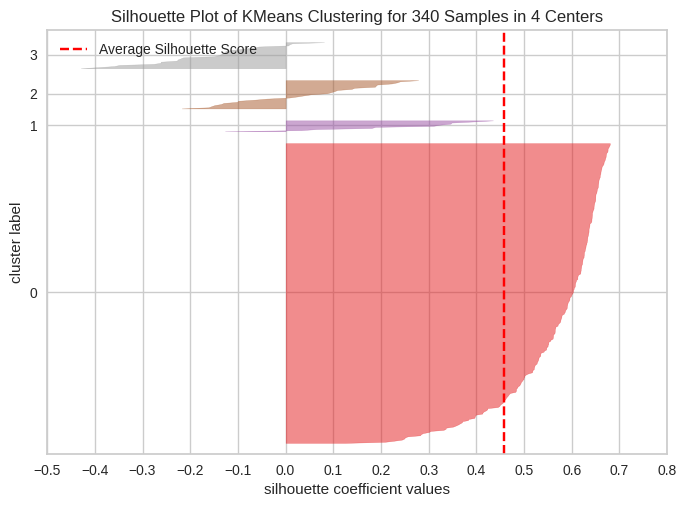

In [79]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show();

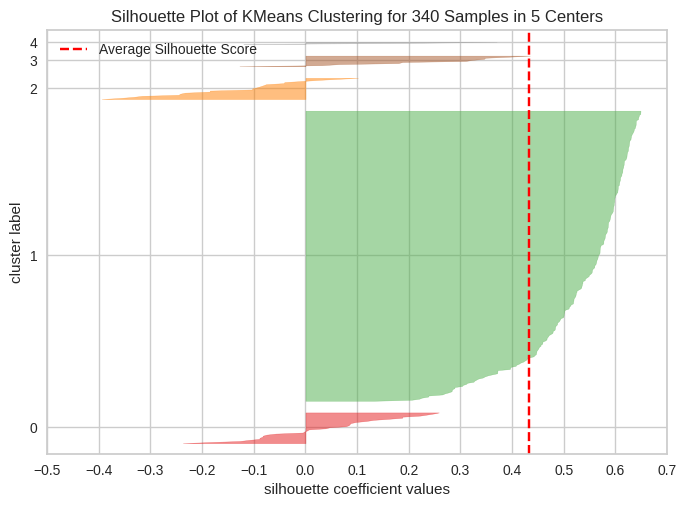

In [80]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show();

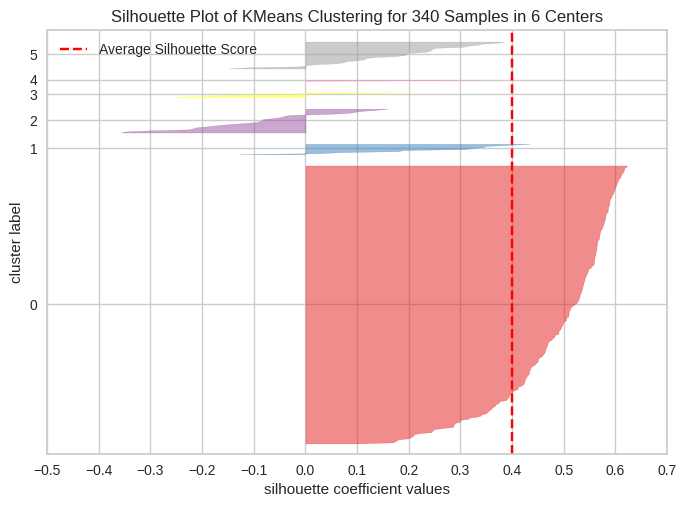

In [81]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show();

In [82]:
# let's take 4 as number of clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=0)

In [84]:
# adding kmeans cluster labels to the original and scaled dataframes
df['K_means_segments'] = kmeans.labels_
subset_scaled_df['K_means_segments'] = kmeans.labels_

**Cluster Profiling**

In [85]:
cluster_profile = df.groupby('K_means_segments').mean()

In [88]:
cluster_profile['count_in_each_segments'] = (df.groupby('K_means_segments')['Current Price'].count().values)

In [89]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [93]:
# names of the companies in each cluster
for comp in df['K_means_segments'].unique():
    print("In cluster {}, the following companies are present:".format(comp))
    print(df[df['K_means_segments'] == comp]['Security'].unique())
    print()

In cluster 3, the following companies are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Archer-Daniels-Midland Co' 'Ameren Corp'
 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'Allegion'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Ameriprise Financial' 'American Tower Corp A' 'AutoNation Inc'
 'Anthem Inc.' 'Aon plc' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Baxter International Inc.' 'BB&T Corporation' 'Bard (C.R.) Inc.'
 'The Bank of New York Mellon Corp.' 'Ball Corp' 'Bristol-Myers Squibb'
 'Boston Scientific' 'BorgWarner' 'Boston Properties' 'Caterpillar Inc.'
 'Chubb Limited' 'CBRE Group' 'Crown Castl

In [94]:
#group clusters by sectors
df.groupby(['K_means_segments', 'GICS Sector'])['Security'].count()

K_means_segments  GICS Sector                
0                 Consumer Discretionary          6
                  Consumer Staples                1
                  Energy                          1
                  Financials                      1
                  Health Care                     9
                  Information Technology          5
                  Real Estate                     1
                  Telecommunications Services     1
1                 Energy                         22
                  Industrials                     1
                  Information Technology          3
                  Materials                       1
2                 Consumer Discretionary          1
                  Consumer Staples                1
                  Energy                          1
                  Financials                      3
                  Health Care                     2
                  Information Technology          1
                  

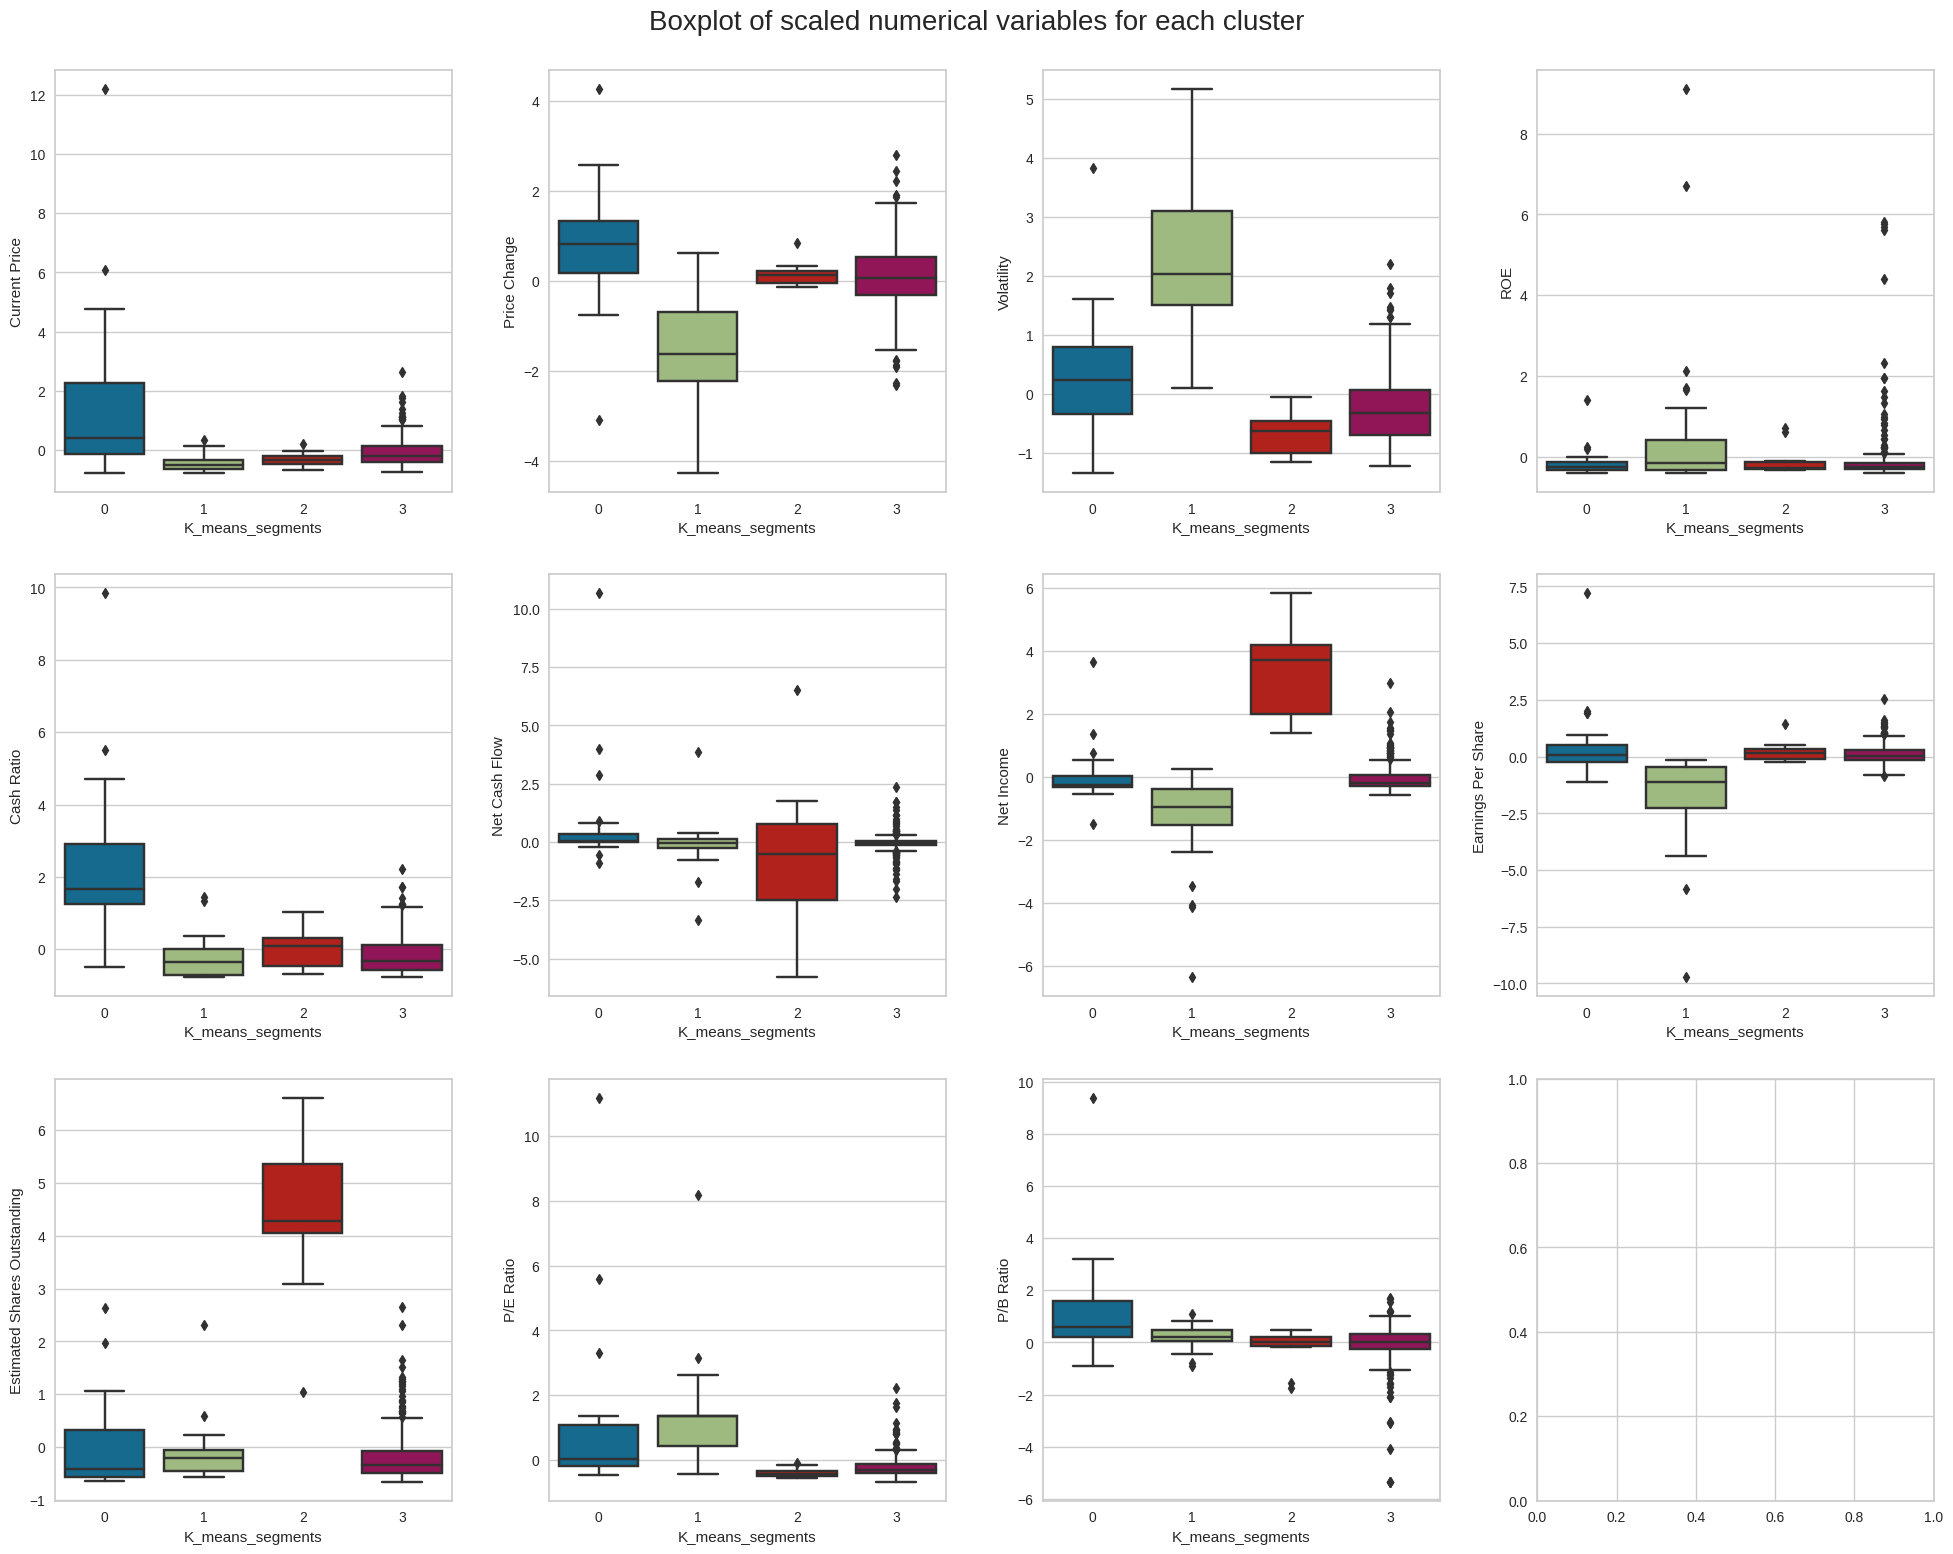

In [98]:
fig, axes = plt.subplots(3, 4,  figsize=(20, 16))
fig.suptitle('Boxplot of scaled numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(3):
    for jj in range(4):
        if counter <11:
            sns.boxplot(ax=axes[ii, jj],y=subset_scaled_df[num_col[counter]],x=subset_scaled_df['K_means_segments'])
        counter = counter+1

fig.tight_layout(pad=2.0)

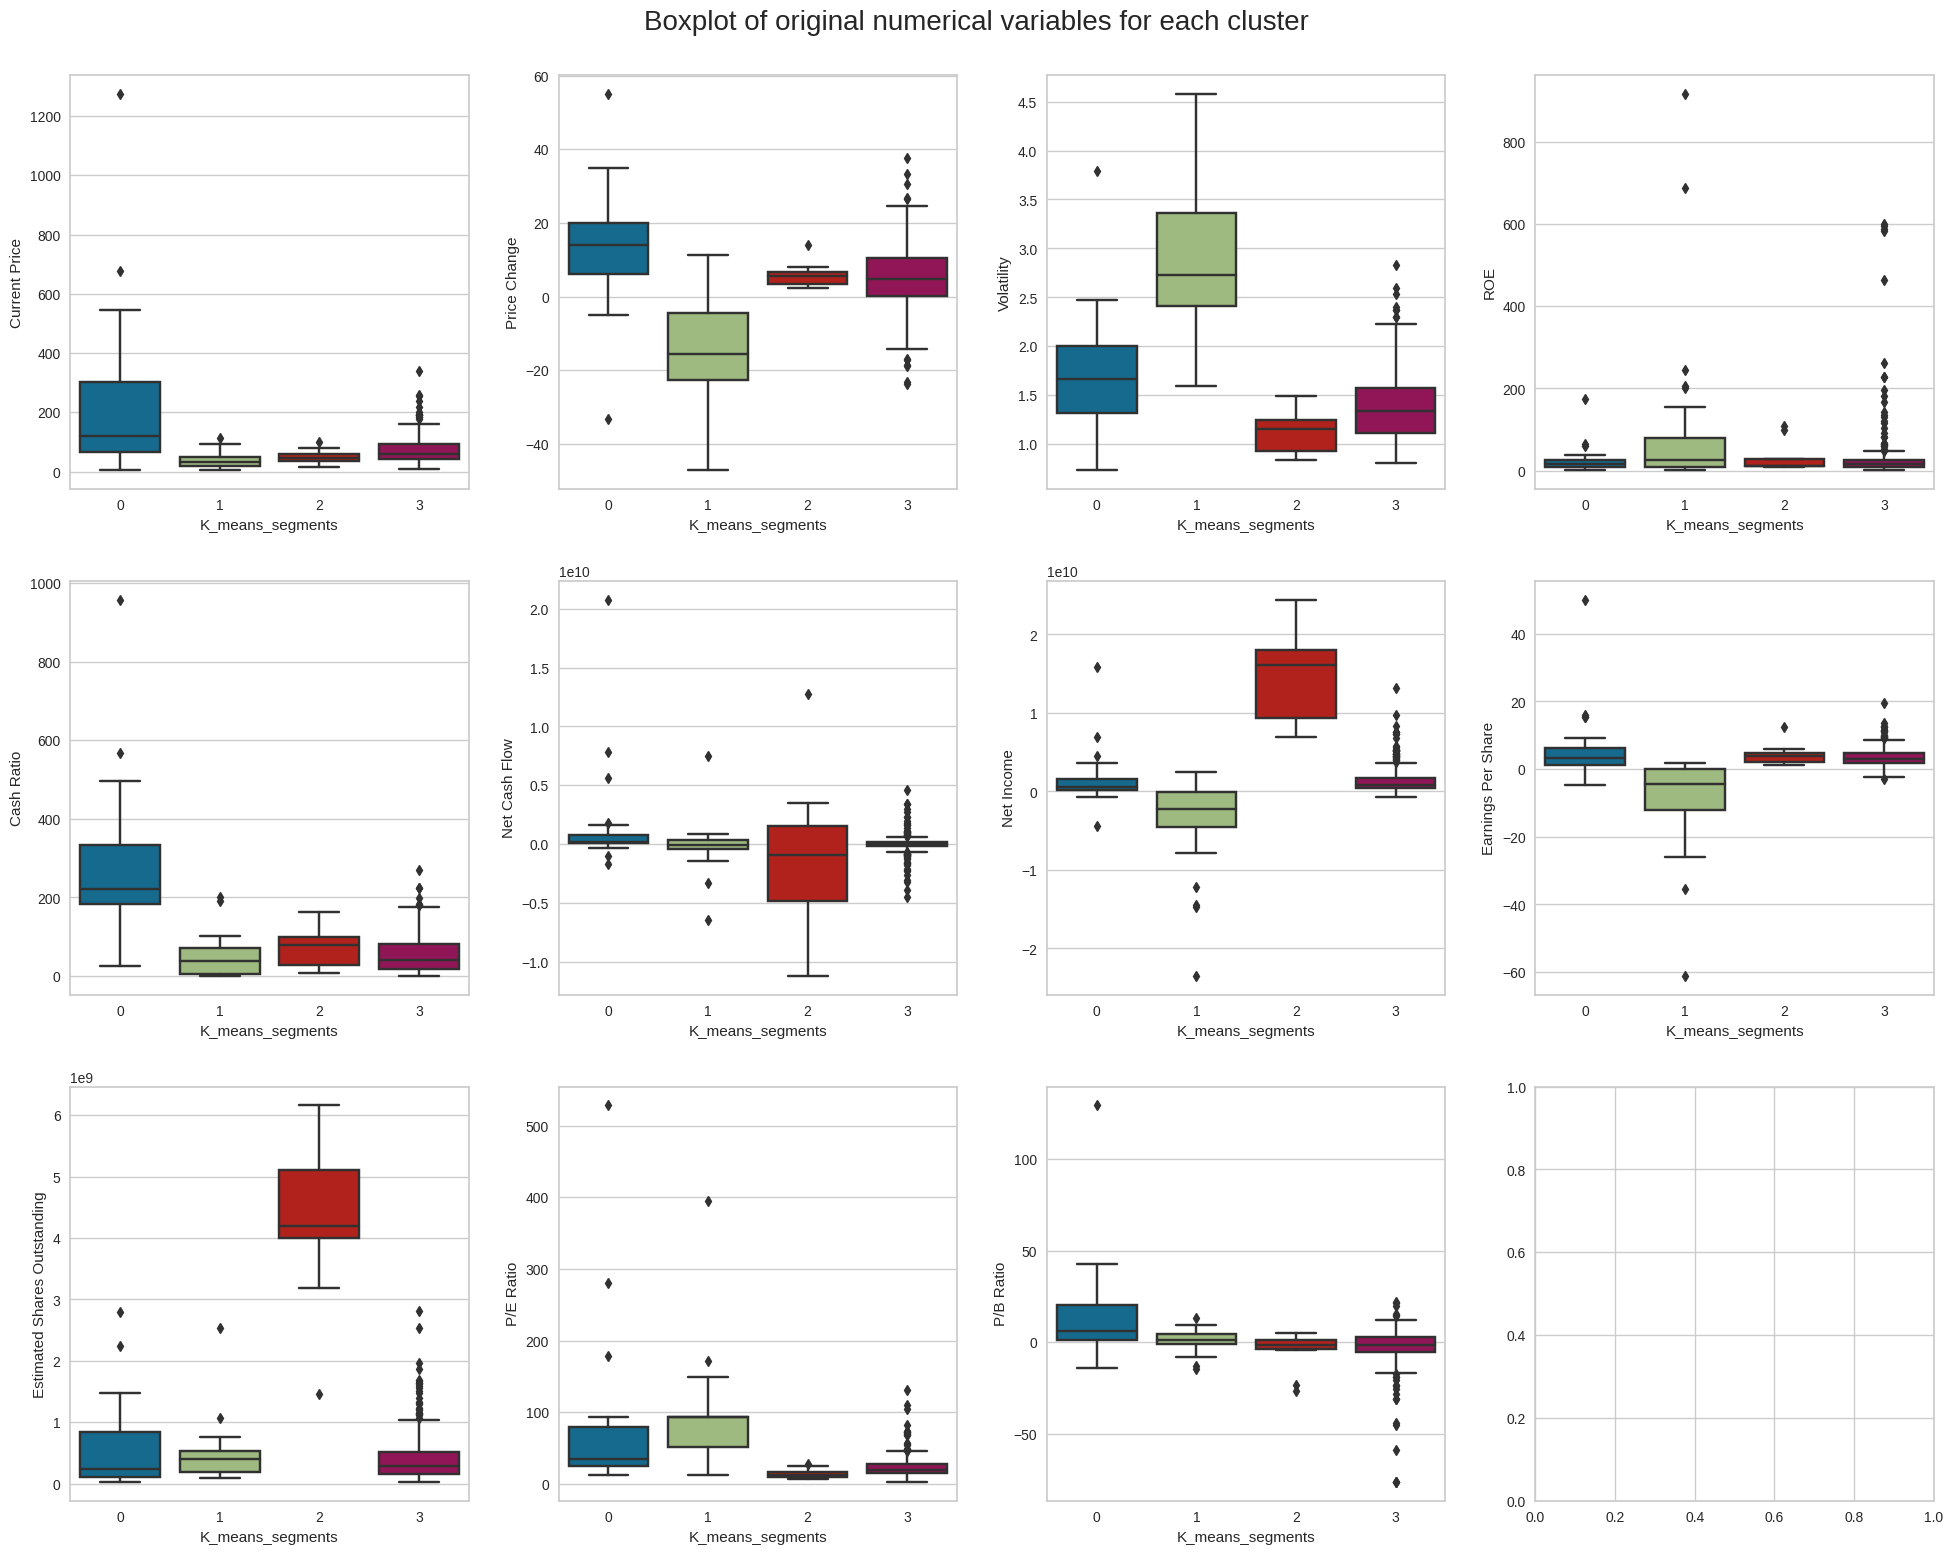

In [99]:
fig, axes = plt.subplots(3, 4,  figsize=(20, 16))
fig.suptitle('Boxplot of original numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(3):
    for jj in range(4):
        if counter <11:
            sns.boxplot(ax=axes[ii, jj],y=df[num_col[counter]],x=df['K_means_segments'])
        counter = counter+1

fig.tight_layout(pad=2.0)

**Insights**

**Cluster 0: Moderate Risk High Gain**
- There are 25 companies
- Consisting mostly of IT, Healthcare and Consumers discretionary
- This is the mostly profitable cluster as it has the highest Cash ratio, Net cash flow and Earnings per share, with moderate volatility

**Cluster 1: High Risk low Gain**
- There are 27 companies
- Consisting of only 3 sectors out of which Energy is the highest
- Negative price change, net income, net cash flowand earnings per share, most volatile stocks

**Cluster 2: Low Risk Moderate Gain**
- There are 11 companies
- Diverse sectors, financials having most stocks
- Highest net income and number of shares outstanding with low volatility and negative net cash flow and moderate earnings per share

**Cluster 3: Moderate Risk Moderate Gain**
- There are 277 companies
- Volatility between cluster 0 and 2
- positive and moderate net income and earnings per share

## Hierarchical Clustering

**Computing Cophenetic Correlation**

In [103]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9304469769832865.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8559480642212798.
Cophenetic correlation for Euclidean distance and average linkage is 0.946403836884538.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.7508819056084053.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9161627445317929.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.822502094153258.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9379218754329659.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9153206618543516.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9348505176633238.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6881861661402056.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9360657692078034.
Cophenetic corr

In [104]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.946403836884538, which is obtained with Euclidean distance and average linkage.


Let's explore different linkage methods with Euclidean distance only

In [105]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.946403836884538, which is obtained with average linkage.


We see that the cophenetic correlation is maximum with Euclidean distance and average linkage

**Checking Dendrograms**

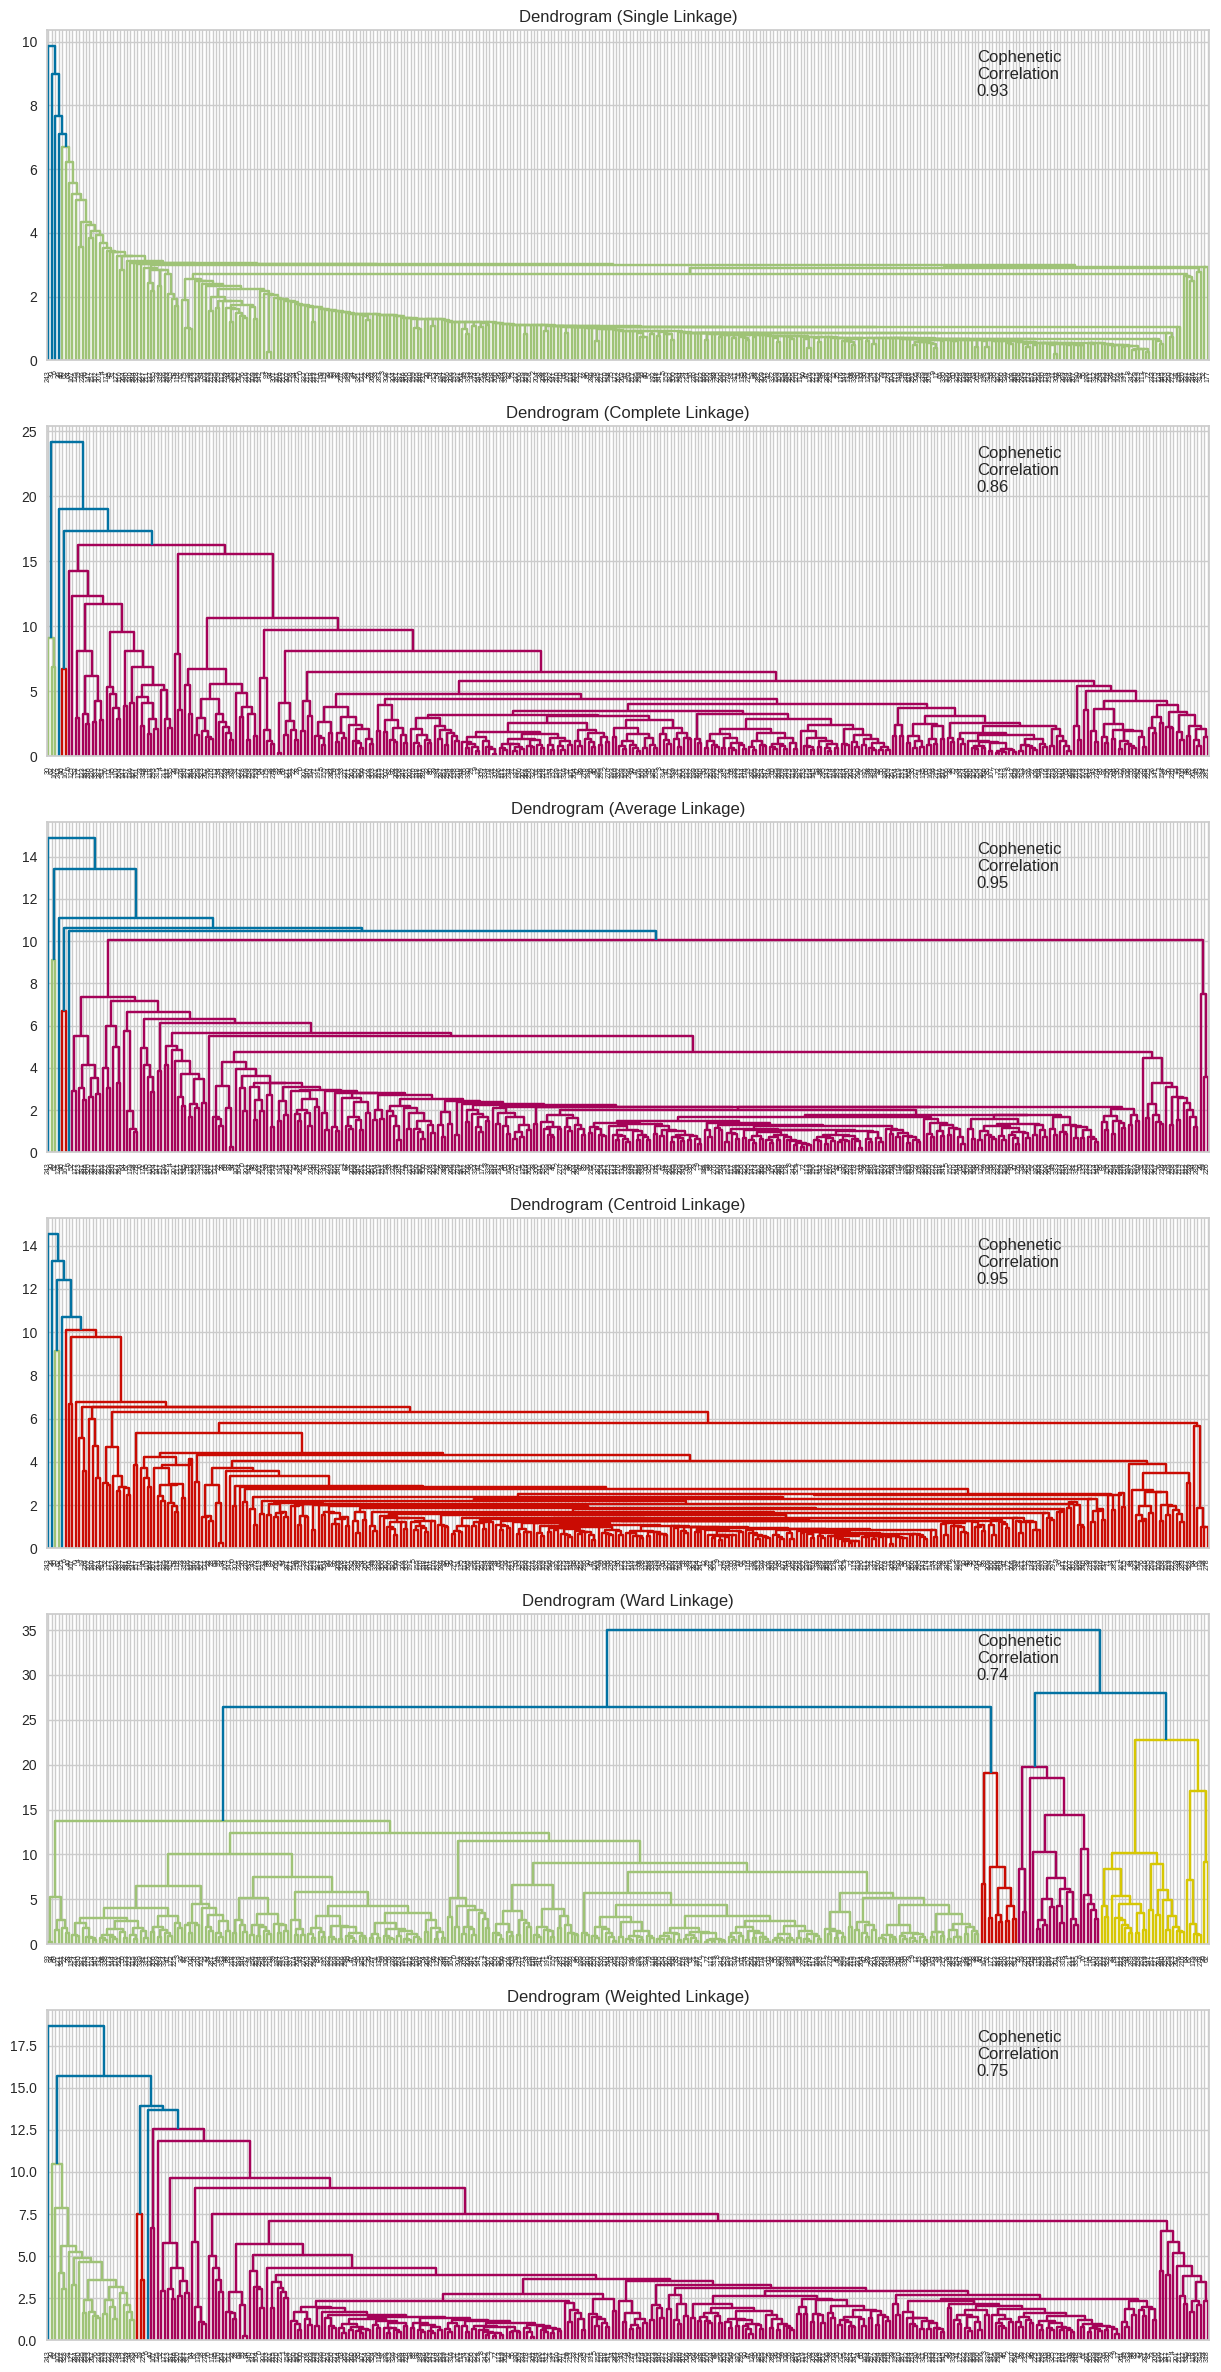

In [106]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [108]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

Linkage  Cophenetic Coefficient
4      ward                    0.74
5  weighted                    0.75
1  complete                    0.86
0    single                    0.93
2   average                    0.95
3  centroid                    0.95

- Although the cophenetic coefficient is more for average and centroid, Dendrogram for Ward linkage shows distinct and separate clusters
- 4 appears to be the appropriate number of clusters from the dendrogram of
ward linkage

**Creating Final Model**

**Let's create 4 clusters**

In [109]:
# 4 clusters, Euclidean distance, and ward linkage
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [110]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

**Cluster Profiling**

In [111]:
cluster_profile = df.groupby("HC_Clusters").mean()

In [113]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Current Price"].count().values
)

In [114]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [119]:
df.groupby(["HC_Clusters", "GICS Sector"])['Security'].count()

HC_Clusters  GICS Sector                
0            Consumer Discretionary          1
             Consumer Staples                2
             Energy                         23
             Financials                      1
             Industrials                     2
             Information Technology          2
             Materials                       1
1            Consumer Discretionary          1
             Consumer Staples                1
             Energy                          1
             Financials                      4
             Health Care                     1
             Information Technology          1
             Telecommunications Services     2
2            Consumer Discretionary          6
             Consumer Staples                1
             Health Care                     9
             Information Technology          6
             Real Estate                     1
             Telecommunications Services     1
3            Consum

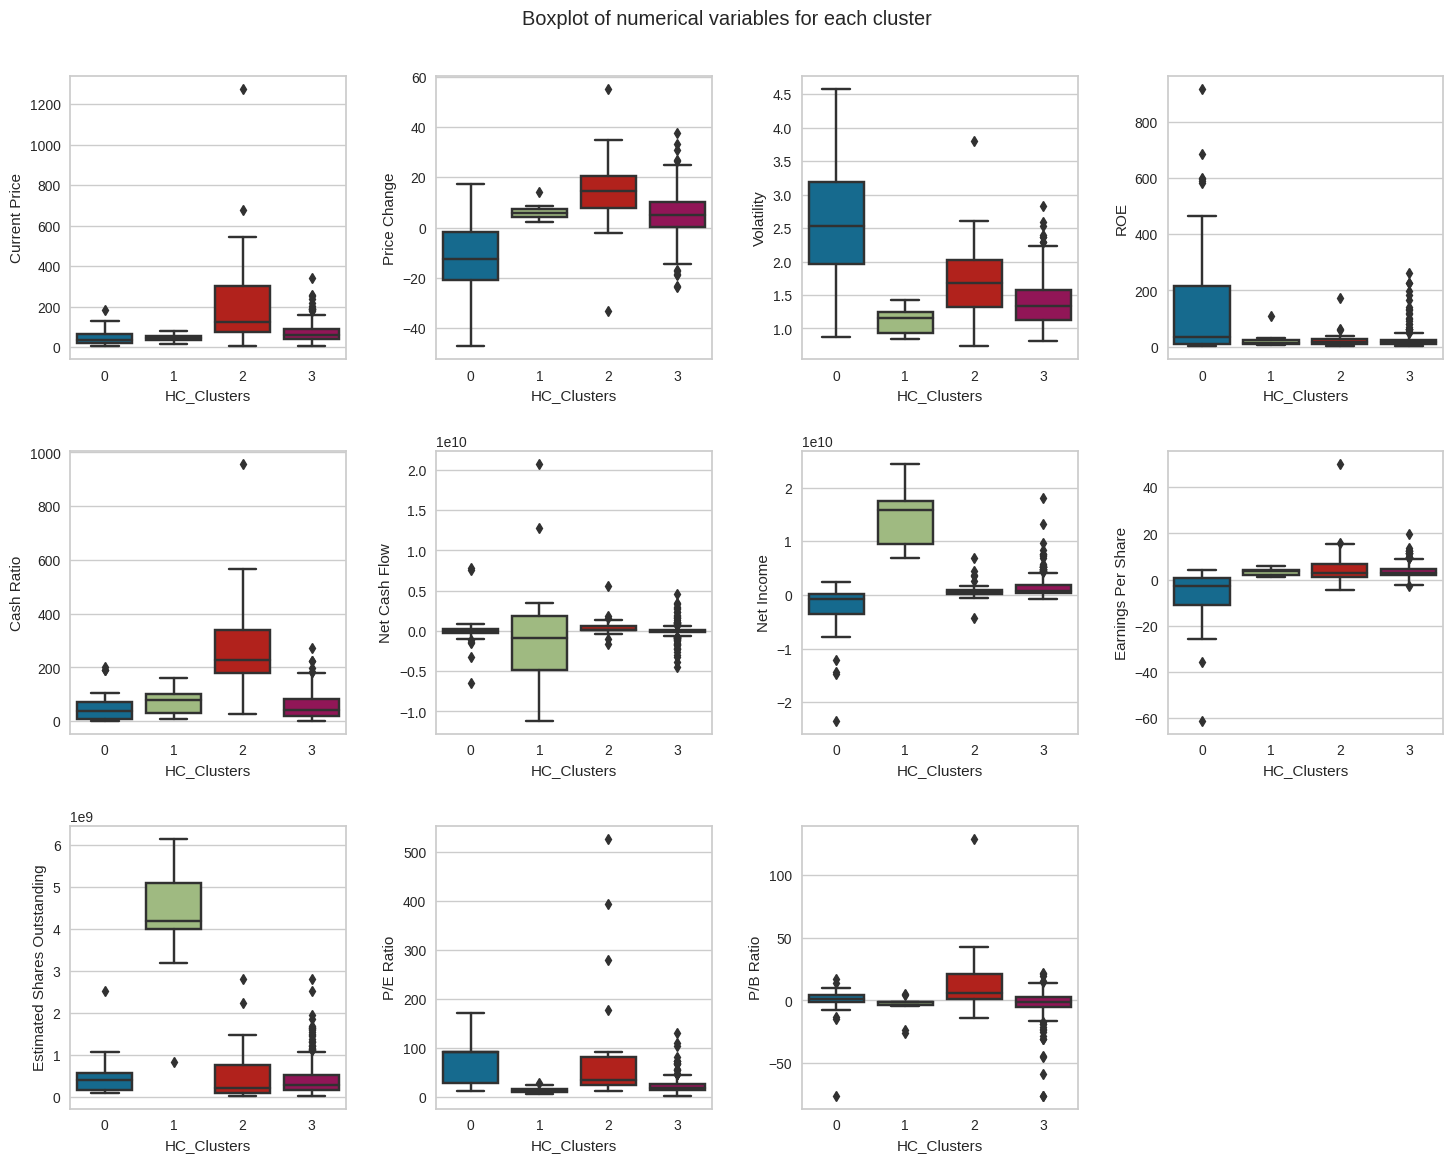

In [117]:
plt.figure(figsize=(15, 12))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

**Insights**

**Cluster 0: High Risk low Gain**
- There are 32 companies
- Same as Cluster 1 of K means

**Cluster 2: Moderate Risk High Gain**
- There are 24 companies
- Same as Cluster 0 of K means

**Cluster 1: Low Risk Moderate Gain**
- There are 11 companies
- Same as Cluster 2 of K means

**Cluster 3: Moderate Risk Moderate Gain**
- There are 273 companies
- Same as Cluster 3 of K means


## K-means vs Hierarchical Clustering


- Which clustering technique took less time for execution?
> Both KMeans and Hierarchical took almost same time
- Which clustering technique gave you more distinct clusters, or are they the same?
?
> Both techniques gave 4 clusters
- How many observations are there in the similar clusters of both algorithms?
> Total 4 clusters were observed, similar clusters of both had similar number of observations, one of the 4 had majority of the stocks
- How many clusters are obtained as the appropriate number of clusters from both algorithms?
> 4

Both clustering techniques gave similar results!

## Actionable Insights and Recommendations

- According to above two clustering algorithms, the stocks could be classified based on risk and gain
- Most of the stocks were of moderate risk and moderate gain
- Trade&Ahead should look for metrics like financial goals, risk tolerance etc in their clients and recommend stocks accordingly
- Clients who do not have a high risk appetite and want to be safe with their money, can be recommended cluster 2 of Kmeans having low risk and moderate gain
- Clients with moderate to high risk appetite looking for moderate to high gain should be recommended cluster 3 and 0 of Kmeans  